# Air Pollution

Data sourse: https://dataratp.opendatasoft.com/explore/?sort=modified

Team: Yuliia Nikolaenko, Lara-Anna Wagner, Mihaela Grigore.

1. Predict CO2 level in a selected station from time of day, past values, temperature and
humidity.
2. Predict NO/NO2/PM10 levels (+PM25 for Auber) in a selected station from past values,
temperature and humidity. Does it help to also consider current CO2 level?
3. Compare models for each stations.
4. Can current levels in two stations help predict levels in third station?
5. Can surface air quality data help predict NO/NO2/PM10/PM25 levels in subway stations?

In [ ]:
import pandas as pd
import numpy as np
import math
from datetime import datetime

!pip install seaborn 
import seaborn as sns

import matplotlib.pyplot as plt

!pip install missingno
import missingno as msno

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, median_absolute_error

!pip install yellowbrick
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

!pip install plotly
import plotly.express as px

!pip install statsmodels

np.set_printoptions(suppress=True)

import plotly.express as px
import plotly.graph_objects as go

In [ ]:
## Air quality at subway stations Auber, Châtelet and Franklin-Roosevelt (2013-2020):
#import dataset Châtelet
df_chatelet = pd.read_csv("data/qualite-de-lair-mesuree-dans-la-station-chatelet.csv", sep=";")

#import dataset Auber
df_auber = pd.read_csv("data/qualite-de-lair-mesuree-dans-la-station-auber.csv", sep=";")

#import dataset Franklin-Roosevelt
df_roosevelt = pd.read_csv("data/qualite-de-lair-mesuree-dans-la-station-franklin-d-roosevelt.csv", sep=";")

##Additional data sources: surface pollution measurement:
#df_chatelet_surface
#df_auber_surface
#df_roosevelt_surface

## Helper Functions

In [ ]:
def convert_time_stamp(d):
    return datetime.strptime(d,"%Y-%m-%dT%H:%M:%S%z")

In [ ]:
#to be used for data engineering

'''
transforms a day of week (from 0=Mon to 6=Sun) into
    1=it's a week-end day or 
    0=it's not week-end)
'''
def weekendYes(x): 
    return 1 if (x>=5) else 0  #ternary operator 
   
'''
transforms a month of year (from 1 to 12) into
    1=it's a summer month (6,7 or 8) 
    0=it's not a summer month)
'''
def summerYes(x):
    return 1 if (6<=x<=8) else 0

In [ ]:
'''
from 'DATE/HEURE' initial feature, creates new features:
    - hour: 0 to 23
    - weekday: 0 to 6
    - weekend: 0 or 1
    - month: 1 to 12
    - summer: 0 or 1
'''
def format_df(df):
    df['hour'] = df['DATE/HEURE'].apply(lambda x: x.hour)
    df['weekday'] = df['DATE/HEURE'].apply(lambda x: x.weekday())
    df['weekend'] = df['weekday'].apply(weekendYes)
    df['month'] = df['DATE/HEURE'].apply(lambda x: x.month)
    df['summer'] = df['month'].apply(summerYes)


# 1. Exploratory Data Analysis #

In [ ]:
df_chatelet.head(10)

DATE/HEURE     NO   NO2   PM10    CO2  TEMP  HUMI
0  2013-03-04T16:00:00+01:00   38.0  62.0  128.0  777.0  17.2  40.4
1  2013-03-04T20:00:00+01:00   51.0  75.0  136.0  843.0  17.8  44.9
2  2013-03-05T22:00:00+01:00   57.0  70.0  149.0  626.0  19.1  38.5
3  2013-03-06T10:00:00+01:00  171.0  94.0  150.0  800.0  18.5  39.0
4  2013-03-08T21:00:00+01:00   31.0  61.0  105.0  800.0  19.9  54.2
5  2013-03-11T06:00:00+01:00    3.0  19.0   15.0  451.0  14.8  44.0
6  2013-03-12T02:00:00+01:00    NaN   NaN    NaN  434.0  14.2  38.7
7  2013-03-13T07:00:00+01:00    5.0  45.0   66.0  493.0  12.6  27.7
8  2013-03-13T23:00:00+01:00    5.0  49.0   90.0  577.0  15.3  36.1
9  2013-03-15T13:00:00+01:00   23.0  69.0  129.0  692.0  15.4  31.0

From the data above, it looks like we can have 1-2 recordings per day and some days are missing.  
Does it just look like this because our data is randomized ?   
To check this assumption, we plot the next station's data ordered by the 'DATE/HEURE' column.

In [ ]:
df_auber.sort_values(by=['DATE/HEURE']).head(10)

DATE/HEURE  NO  NO2   PM10  PM2.5    CO2  TEMP  HUMI
35112  2013-01-01T02:00:00+01:00 NaN  NaN  243.0   96.0  465.0  20.5  50.6
23871  2013-01-01T03:00:00+01:00 NaN  NaN  141.0   55.0  434.0  20.3  50.4
46206  2013-01-01T04:00:00+01:00 NaN  NaN  157.0   62.0  425.0  20.1  50.4
30329  2013-01-01T05:00:00+01:00 NaN  NaN  134.0   52.0  405.0  20.2  50.5
25205  2013-01-01T06:00:00+01:00 NaN  NaN  133.0   48.0  398.0  20.1  50.2
30331  2013-01-01T07:00:00+01:00 NaN  NaN  382.0  120.0  419.0  20.4  50.7
18460  2013-01-01T08:00:00+01:00 NaN  NaN  246.0   96.0  411.0  20.6  50.7
5036   2013-01-01T09:00:00+01:00 NaN  NaN  328.0  131.0  406.0  20.5  50.9
17148  2013-01-01T10:00:00+01:00 NaN  NaN  295.0  118.0  403.0  20.4  51.2
30333  2013-01-01T11:00:00+01:00 NaN  NaN  282.0  105.0  402.0  20.3  49.8

It looks like our data was just randomized. We actually have one recording per hour.  
Our recordings start in 2013. How many years of data do we have ?

In [ ]:
df_auber.sort_values(by=['DATE/HEURE']).tail(5)

DATE/HEURE  NO  NO2  PM10  PM2.5  CO2  TEMP  HUMI
63992  2020-11-01T21:00:00+01:00 NaN  NaN   NaN    NaN  NaN   NaN   NaN
64244  2020-11-01T22:00:00+01:00 NaN  NaN   NaN    NaN  NaN   NaN   NaN
64245  2020-11-01T23:00:00+01:00 NaN  NaN   NaN    NaN  NaN   NaN   NaN
64246  2020-11-02T00:00:00+01:00 NaN  NaN   NaN    NaN  NaN   NaN   NaN
67171  2020-11-02T01:00:00+01:00 NaN  NaN   NaN    NaN  NaN   NaN   NaN

In [ ]:
df_roosevelt.sort_values(by=['date/heure']).head(10)

date/heure    NO   NO2  PM10    CO2  TEMP  HUMI
52853  2013-01-01T02:00:00+01:00  23.0  41.0  26.0  612.0  15.1  65.6
59240  2013-01-01T03:00:00+01:00  43.0  61.0  18.0  536.0  14.9  65.0
59243  2013-01-01T04:00:00+01:00  22.0  52.0  45.0  490.0  14.9  63.3
52855  2013-01-01T05:00:00+01:00  27.0  56.0  22.0  481.0  14.9  63.7
52526  2013-01-01T06:00:00+01:00  27.0  57.0  15.0  464.0  15.0  63.3
57902  2013-01-01T07:00:00+01:00  20.0  50.0  17.0  455.0  15.1  63.2
57905  2013-01-01T08:00:00+01:00  24.0  51.0  17.0  442.0  14.9  63.7
57908  2013-01-01T09:00:00+01:00  10.0  37.0  20.0  426.0  14.8  64.1
52857  2013-01-01T10:00:00+01:00  11.0  40.0  13.0  427.0  14.5  64.0
57911  2013-01-01T11:00:00+01:00  11.0  42.0   7.0  431.0  14.4  61.7

Observations:  
-  7 years worth of data
- features represents:
    - air composition: NO, NO2, PM10, CO2
    - temperature and humidity
- time resolution: 1 recording per hour

## 1.1 Descriptive Statistics ##

In [ ]:
df_chatelet.describe()

NO           NO2          PM10           CO2          TEMP  \
count  41916.000000  51602.000000  53928.000000  53597.000000  58038.000000   
mean      27.173705     36.070036    132.238818    582.918801     21.604149   
std       37.233278     14.778388     92.929099    134.662067      3.649869   
min        2.000000      5.000000      5.000000    383.000000     10.800000   
25%        6.000000     26.000000     73.000000    471.000000     19.100000   
50%       14.000000     34.000000    118.000000    561.000000     21.400000   
75%       33.000000     44.000000    176.000000    665.000000     24.300000   
max      768.000000    360.000000    999.000000   2321.000000     31.700000   

               HUMI  
count  58039.000000  
mean      44.232128  
std        8.948186  
min       16.800000  
25%       38.200000  
50%       43.500000  
75%       49.500000  
max      100.000000

In [ ]:
df_auber.describe()

NO           NO2          PM10         PM2.5           CO2  \
count  43502.000000  44122.000000  45962.000000  44744.000000  44158.000000   
mean      56.052848     53.206518    143.257865     62.242848    535.925540   
std       69.175808     29.529757    114.485244     49.227822    107.273196   
min        2.000000      6.000000      5.000000      2.000000    390.000000   
25%       16.000000     39.000000     72.000000     31.000000    451.000000   
50%       38.000000     50.000000    114.000000     50.000000    514.000000   
75%       73.000000     62.000000    182.000000     79.000000    591.000000   
max     1263.000000    931.000000   2584.000000    970.000000   1250.000000   

               TEMP          HUMI  
count  47255.000000  47266.000000  
mean      21.332767     44.201870  
std        3.851610      7.203966  
min        9.500000     19.000000  
25%       18.100000     39.200000  
50%       21.300000     44.200000  
75%       24.400000     49.200000  
max       32.600000     68.600000

In [ ]:
df_roosevelt.describe()

NO           NO2          PM10           CO2          TEMP  \
count  60465.000000  61879.000000  64775.000000  62485.000000  66705.000000   
mean      37.675614     55.413711     45.683582    484.919629     19.329425   
std       43.354987     22.378601     42.660336     59.089710      4.940742   
min        1.000000      4.000000      5.000000    381.000000      3.800000   
25%       10.000000     40.000000     23.000000    442.000000     15.700000   
50%       23.000000     55.000000     35.000000    475.000000     19.000000   
75%       50.000000     69.000000     52.000000    515.000000     23.100000   
max      929.000000    265.000000    979.000000   1056.000000     35.200000   

               HUMI  
count  66698.000000  
mean      47.765497  
std       10.375634  
min       13.100000  
25%       40.600000  
50%       47.500000  
75%       54.800000  
max       95.400000

Observations:   
- all features are numerical continuous variables 
- judging from the quartile values and the max values, they all seem to contain outliers. We will see them better in the data visualization section.

## 1.2 Missing values

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


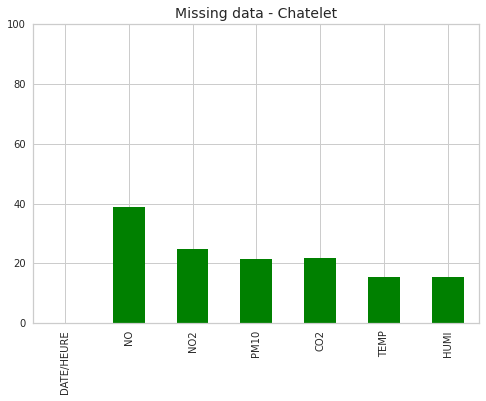

In [ ]:
s = (df_chatelet.isnull().sum() / len(df_chatelet)*100).copy()
s.plot.bar(color="green", ylim=(0,100))
plt.title('Missing data - Chatelet', fontsize = 14)
plt.show()

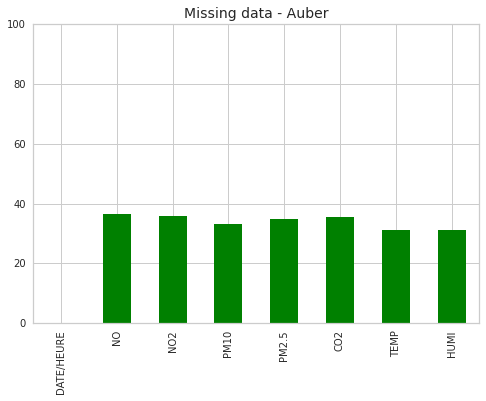

In [ ]:
s = (df_auber.isnull().sum() / len(df_auber)*100).copy()
s.plot.bar(color="green", ylim=(0,100))
plt.title('Missing data - Auber', fontsize = 14)
plt.show()

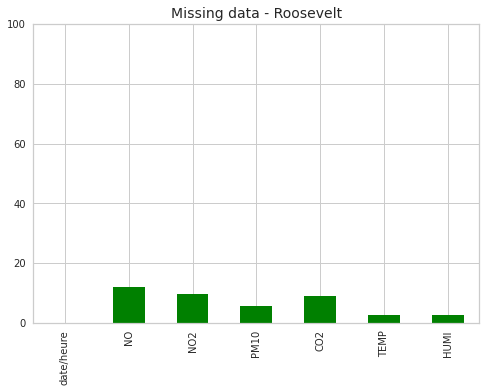

In [ ]:
s = (df_roosevelt.isnull().sum() / len(df_roosevelt)*100).copy()
s.plot.bar(color="green", ylim=(0,100))
plt.title('Missing data - Roosevelt', fontsize = 14)
plt.show()

Observations:  
- Chatelet and Auber have a high percentage of missing values (up to 40% for some features).
- FR is missing way less values  
- however, out datasets have ~58.000 (Chatelet), ~47.000 (Auber) and ~68.000 (F.R.), so we can remove the exemplars withe missing values and still have a high amount of data

A more graphical and intuitive way to graps the amount of missing values:

<AxesSubplot:>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


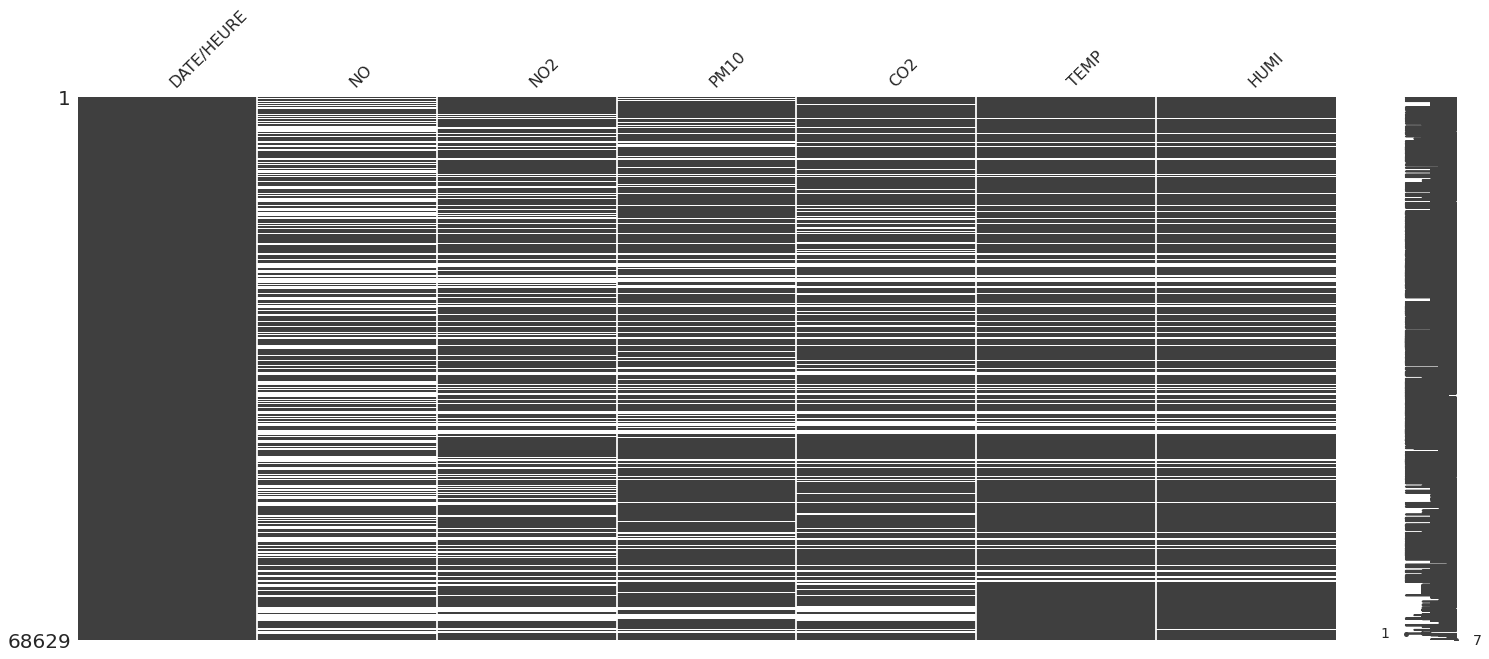

In [ ]:
msno.matrix(df_chatelet)

<AxesSubplot:>

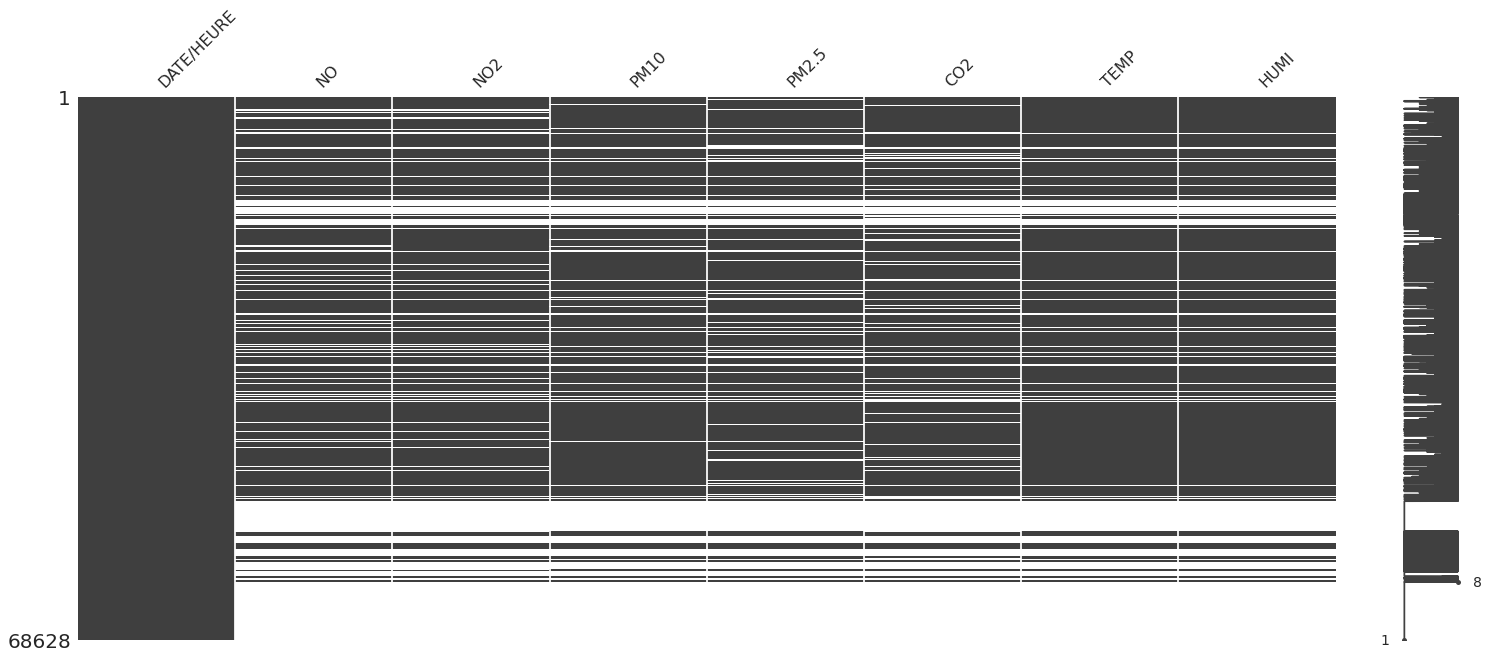

In [ ]:
msno.matrix(df_auber)

<AxesSubplot:>

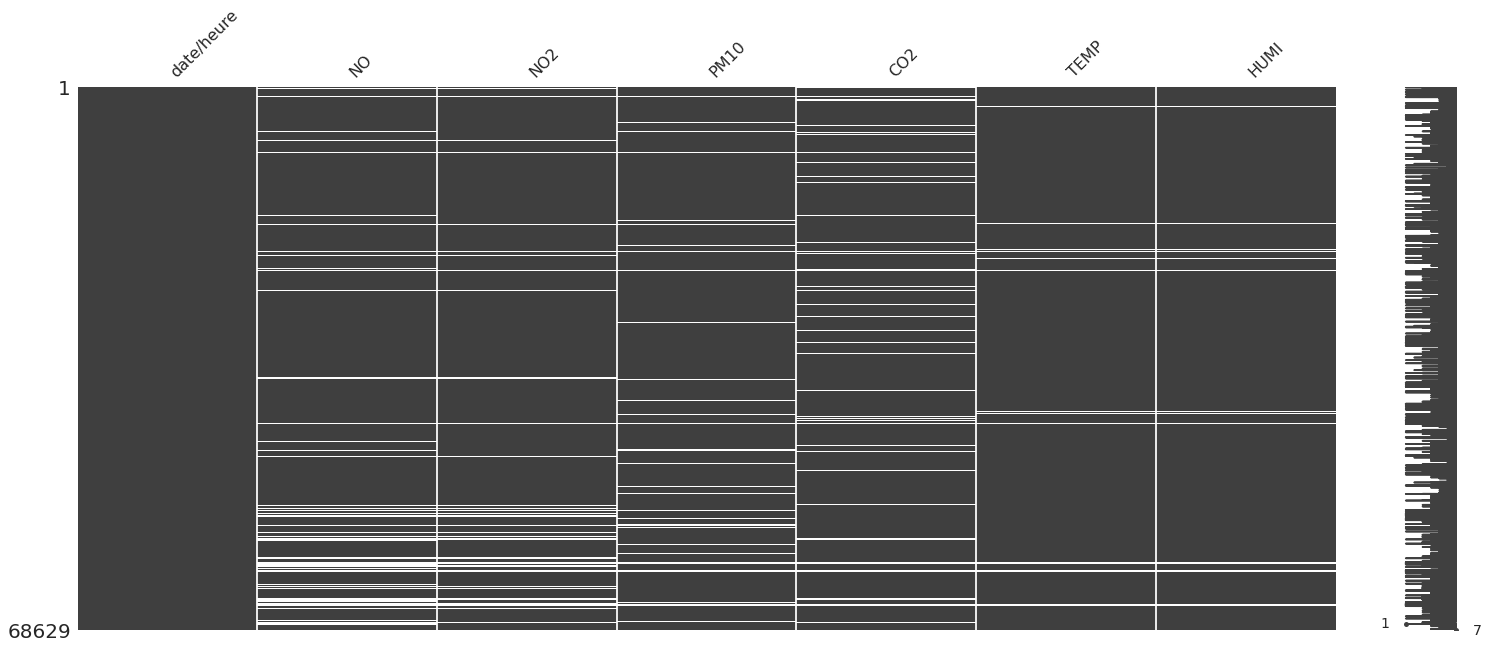

In [ ]:
msno.matrix(df_roosevelt)

## 1.3 Preliminary Data engineering

In [ ]:
# Convert column header to uppercase to match other df's
df_roosevelt.columns = df_roosevelt.columns.str.upper()

In [ ]:
# convert time stamp str to datetime
df_chatelet['DATE/HEURE'] = df_chatelet['DATE/HEURE'].apply(lambda x: convert_time_stamp(x))
df_auber['DATE/HEURE'] = df_auber['DATE/HEURE'].apply(lambda x: convert_time_stamp(x))
df_roosevelt['DATE/HEURE'] = df_roosevelt['DATE/HEURE'].apply(lambda x: convert_time_stamp(x))

In [ ]:
format_df(df_chatelet)
format_df(df_auber)
format_df(df_roosevelt)

## 1.3 Data visualization ##

### 1.3.1 Single variable analysis ###

Let's examine histograms to see the distribution of our features

array([[<AxesSubplot:title={'center':'CO2'}>,
        <AxesSubplot:title={'center':'HUMI'}>],
       [<AxesSubplot:title={'center':'NO'}>,
        <AxesSubplot:title={'center':'NO2'}>],
       [<AxesSubplot:title={'center':'PM10'}>,
        <AxesSubplot:title={'center':'TEMP'}>]], dtype=object)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


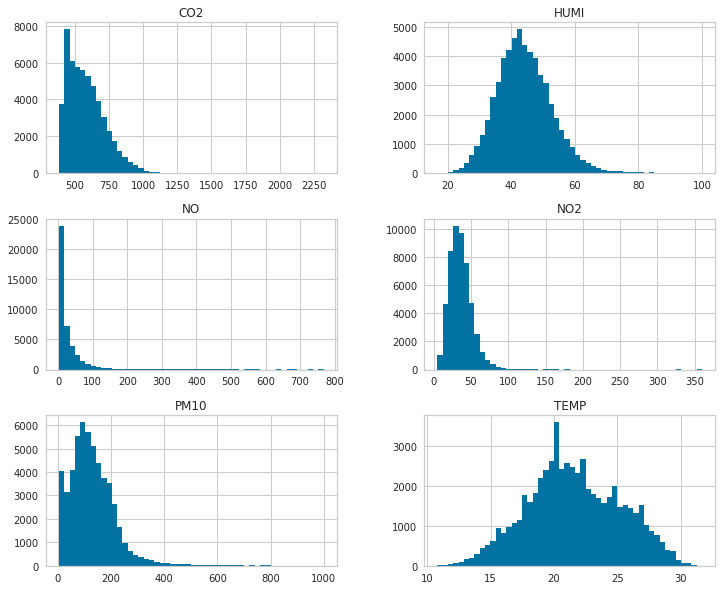

In [ ]:
df_chatelet.columns
col = ['DATE/HEURE', 'NO', 'NO2', 'PM10', 'CO2', 'TEMP', 'HUMI']
df_chatelet.hist(col, figsize=(12,10), bins=50)

Observations:  
1. Humidity and Temperature are normally distributed, which we would expect  
2. CO2, NO, NO2, PM10 are right-skewed, which we would also expect. 
3. CO2, NO, NO2, PM10 have outliers. Let's examine boxplots to get a better feel of the amount of outliers

Text(0.5, 1.0, 'Box plots for CO2, NO, NO2, PM10 - Chatelet dataset')

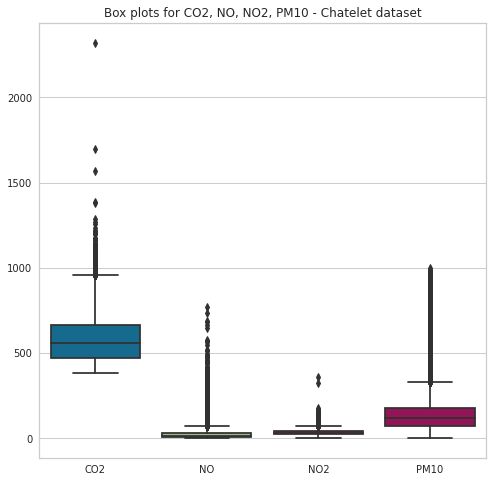

In [ ]:
plt.figure(figsize=(8,8))
#sns.boxplot(data=df_chatelet)
sns.boxplot(data=df_chatelet[['CO2', 'NO', 'NO2', 'PM10']])
plt.title('Box plots for CO2, NO, NO2, PM10 - Chatelet dataset')

Text(0.5, 1.0, 'Box plots for CO2, NO, NO2, PM10 - Auber dataset')

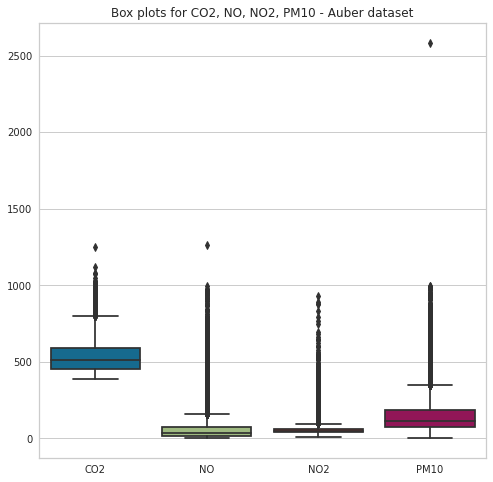

In [ ]:
plt.figure(figsize=(8,8))
sns.boxplot(data=df_auber[['CO2', 'NO', 'NO2', 'PM10']])
plt.title('Box plots for CO2, NO, NO2, PM10 - Auber dataset')

Text(0.5, 1.0, 'Box plots for CO2, NO, NO2, PM10 - F.R. dataset')

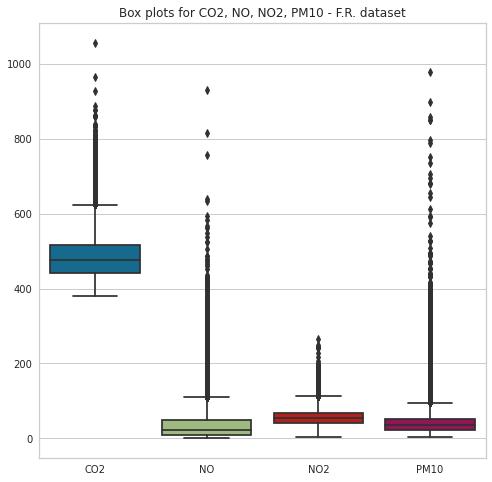

In [ ]:
plt.figure(figsize=(8,8))
sns.boxplot(data=df_roosevelt[['CO2', 'NO', 'NO2', 'PM10']])
plt.title('Box plots for CO2, NO, NO2, PM10 - F.R. dataset')

In [ ]:
#df_chatelet.plot('weekend',kind="bar")

### 1.2.2 Multi-variable analysis / plot ###

*Correlations*

Text(0.5, 1.0, 'Chatelet heatmap')

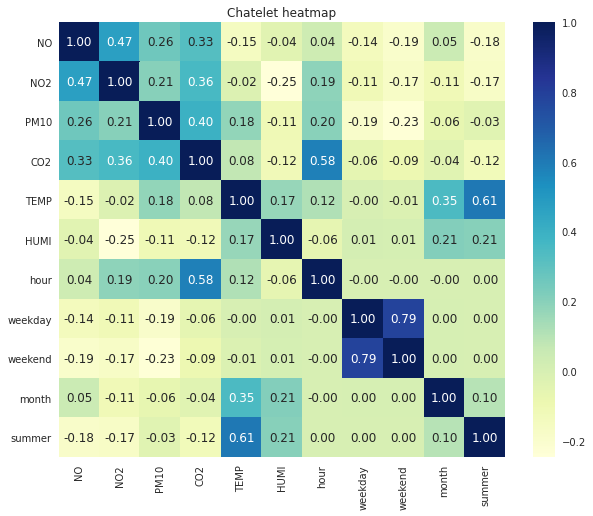

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df_chatelet.corr(),annot=True,cmap="YlGnBu",fmt='.2f')
plt.title('Chatelet heatmap')

Text(0.5, 1.0, 'Auber heatmap')

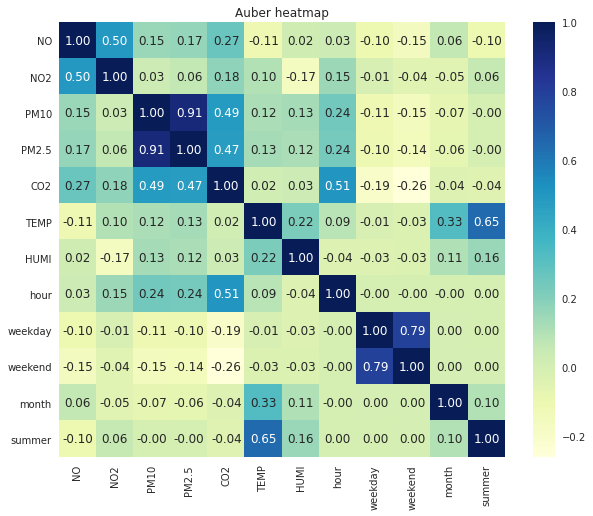

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df_auber.corr(),annot=True,cmap="YlGnBu",fmt='.2f')
plt.title('Auber heatmap')

Text(0.5, 1.0, 'F.R. heatmap')

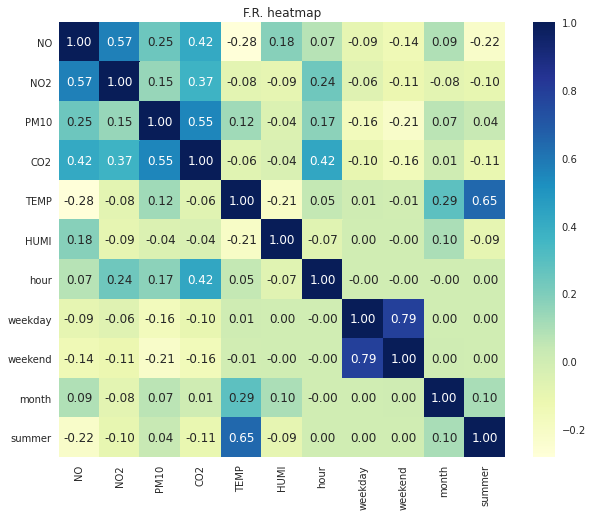

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df_roosevelt.corr(),annot=True,cmap="YlGnBu",fmt='.2f')
plt.title('F.R. heatmap')

Observations:  
- CO2 correlates strongest with 'hour'
- and then NO,NO2,PM10
- NO and NO2 correlate less with CO2 in the 2nd statio (Auber)

*Daily trends in CO2*

/opt/venv/lib/python3.7/site-packages/seaborn/categorical.py:3737: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 8.960000000000015, "['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']")

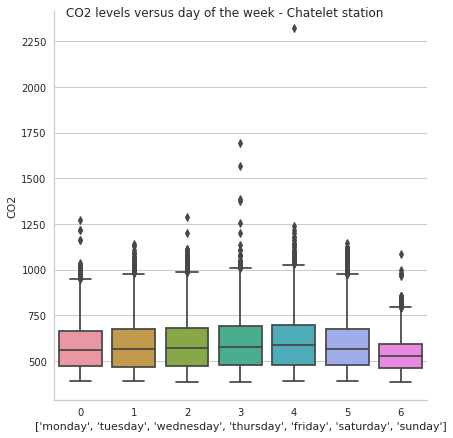

In [ ]:
ax = sns.catplot(x="weekday", y="CO2", kind="box", data=df_chatelet, size=6, aspect=1)
ax.fig.suptitle('CO2 levels versus day of the week - Chatelet station', fontsize=12)
plt.xlabel(["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"])

/opt/venv/lib/python3.7/site-packages/seaborn/categorical.py:3737: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 8.960000000000015, "['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']")

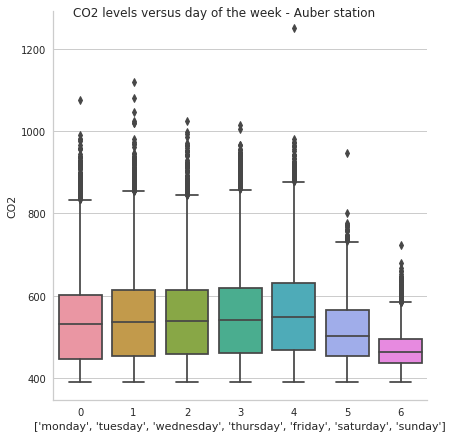

In [ ]:
ax = sns.catplot(x="weekday", y="CO2", kind="box", data=df_auber, size=6, aspect=1)
ax.fig.suptitle('CO2 levels versus day of the week - Auber station', fontsize=12)
plt.xlabel(["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"])

/opt/venv/lib/python3.7/site-packages/seaborn/categorical.py:3737: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 8.960000000000015, "['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']")

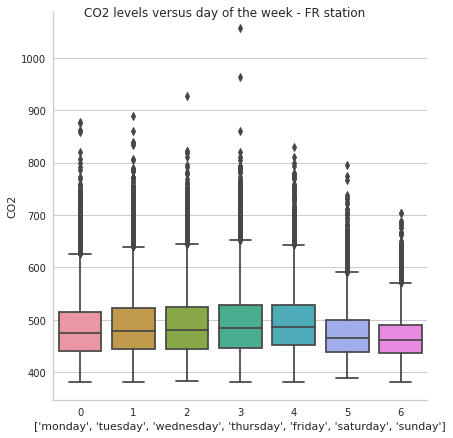

In [ ]:
ax = sns.catplot(x="weekday", y="CO2", kind="box", data=df_roosevelt, size=6, aspect=1 )
ax.fig.suptitle('CO2 levels versus day of the week - FR station', fontsize=12)
plt.xlabel(["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"])

Observations:  
- CO2 is building up from Monday until Sunday  
- and then slowly decreasing during week end  
- there are some outliers in particular days. Are those rush hour values or real outliers ? We explore this question in the plots below.

But first, we remove the clear outlier from Chatelen from day 4.

In [ ]:
indexNames = df_chatelet[ df_chatelet['CO2'] > 2000 ].index
df_chatelet_clean = df_chatelet.drop(indexNames)

*Closer exploration of CO2 by hour of day for each bay*  
*Better visualization of possible outliers*

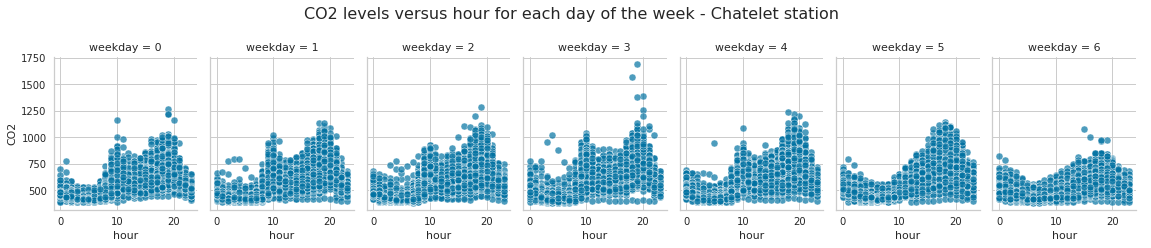

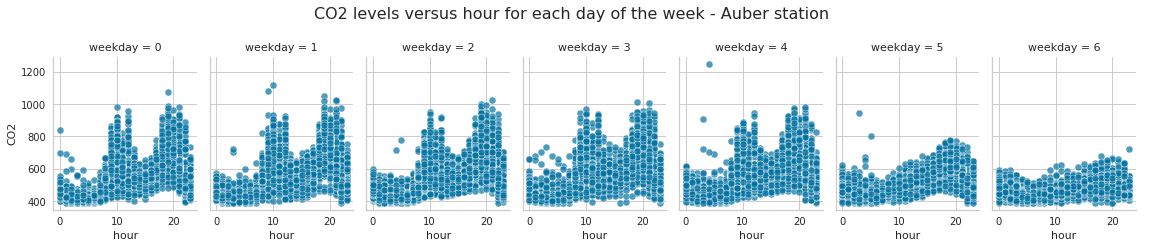

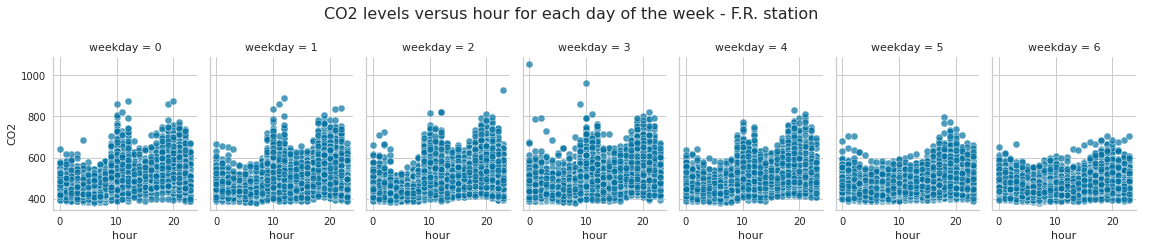

In [ ]:
ax = sns.FacetGrid(df_chatelet_clean, col="weekday",  height=3.5, aspect=.65)
ax.map(sns.scatterplot, "hour", "CO2", alpha=.7)
ax.add_legend()
ax.fig.suptitle('CO2 levels versus hour for each day of the week - Chatelet station', fontsize=16)
plt.tight_layout()

ax = sns.FacetGrid(df_auber, col="weekday",  height=3.5, aspect=.65)
ax.map(sns.scatterplot, "hour", "CO2", alpha=.7)
ax.add_legend()
ax.fig.suptitle('CO2 levels versus hour for each day of the week - Auber station', fontsize=16)
plt.tight_layout()

ax = sns.FacetGrid(df_roosevelt, col="weekday",  height=3.5, aspect=.65)
ax.map(sns.scatterplot, "hour", "CO2", alpha=.7)
ax.add_legend()
ax.fig.suptitle('CO2 levels versus hour for each day of the week - F.R. station', fontsize=16)
plt.tight_layout()

### 1. Predict CO2 level in a selected station from time of day, past values, temperature and humidity.

In [ ]:
def cross_validation(X, Y):
    score = cross_val_score(LinearRegression(), X, Y,cv=5, scoring="r2")
    print('R_squared Mean Score:',score.mean())
    print(score)

In [ ]:
# drop NA for chatelet data 
df_chatelet_clean = df_chatelet_clean.dropna()
print(df_chatelet_clean.shape)
#df_chatelet_clean.head()

(37831, 12)


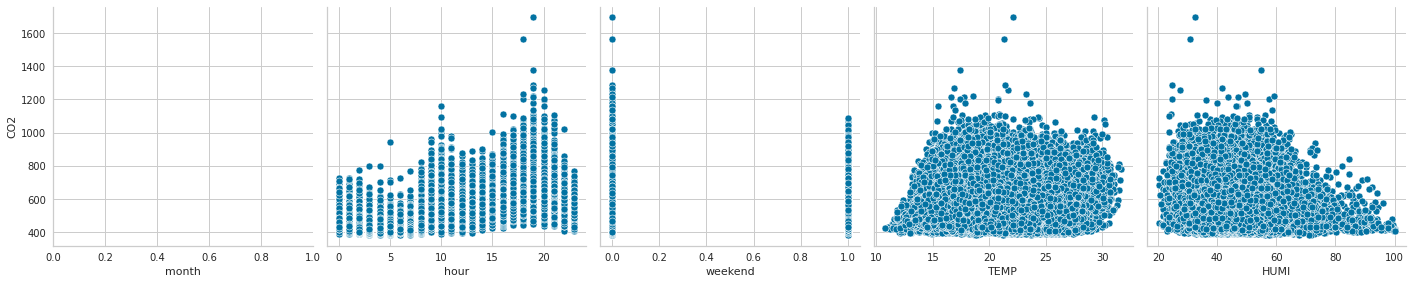

In [ ]:
# Using pairplot we'll visualize the data for correlation
sns.pairplot(df_chatelet_clean, x_vars=['month','hour','weekend','TEMP','HUMI'], 
             y_vars='CO2', height=4, aspect=1, kind='scatter')
plt.show()

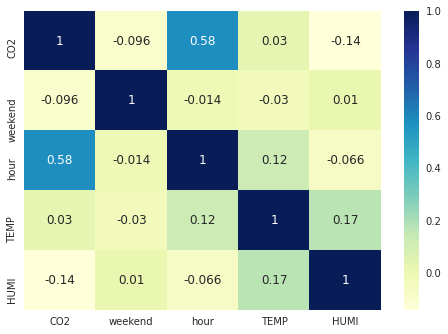

In [ ]:
sns.heatmap(df_chatelet_clean[['CO2','weekend','hour','TEMP','HUMI']].corr(), cmap="YlGnBu", annot = True)
plt.show()

Observations:  
- CO2 correaltes strongest with 'hour'
- only a light correlation with temperature

In [ ]:
def create_lin_reg(X,Y):
    X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.30, random_state=42)
    X_tr = np.array(X_tr).reshape(-1, 1)
    Y_tr = np.array(Y_tr).reshape(-1, 1)
    X_ts = np.array(X_ts).reshape(-1, 1)
    Y_ts = np.array(Y_ts).reshape(-1, 1)

    #sc_X = StandardScaler()
    #X_tr = sc_X.fit_transform(X_tr)
    #X_ts = sc_X.fit_transform(X_ts)

    # instantiate the regressor class
    lin_reg = LinearRegression()
    # make a prediction set using the test set
    lin_reg.fit(X_tr, Y_tr)
    # make a prediction set using the test set
    y_prediction = lin_reg.predict(X_ts)

    # model evaluation
    mse = mean_squared_error(Y_ts, y_prediction)
    r2 = r2_score(Y_ts, y_prediction)

 
    print('Slope:' ,lin_reg.coef_)
    print('Intercept:', lin_reg.intercept_)
    print("Mean squared error: %.2f" %mse)
    print("Root mean squared error: %.2f" %math.sqrt(mse))
    print('R2 score: ', r2)


    plt.figure(figsize=(12,8))
    #plt.scatter(X_tr.squeeze(), Y_tr,  color='#67c2f7', alpha = 0.4, edgecolor = 'white',marker=".")
    plt.scatter(X_ts.squeeze(), Y_ts,  color='#afef77', alpha = 0.4, edgecolor = 'white', marker=".")
    plt.plot(X_ts, y_prediction, color='#3D88BC', linewidth=2)
    plt.xlabel(X.columns[0])
    plt.ylabel(Y.columns[0])
    plt.title(f'{Y.columns[0]} vs. {X.columns[0]}', fontsize = 14)

    plt.show()


    # Instantiate the linear model and visualizer
    visualizer = ResidualsPlot(lin_reg)

    visualizer.fit(X_tr, Y_tr)  # Fit the training data to the visualizer
    visualizer.score(X_ts, Y_ts)  # Evaluate the model on the test data
    visualizer.show()                 # Finalize and render the figure


Slope: [[10.7632108]]
Intercept: [456.22381385]
Mean squared error: 10692.21
Root mean squared error: 103.40
R2 score:  0.33499209487326176


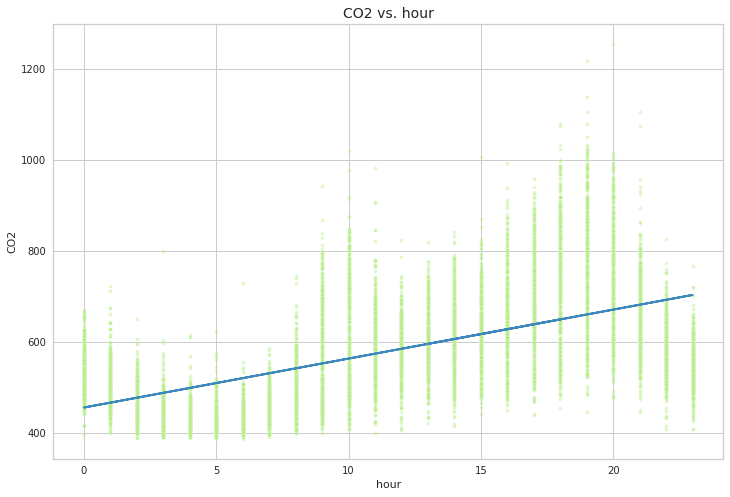

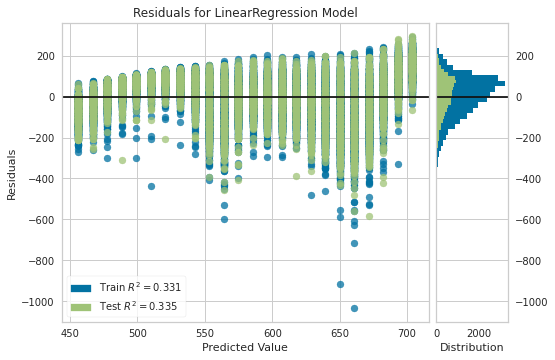

In [ ]:
create_lin_reg(df_chatelet_clean['hour'].to_frame(),df_chatelet_clean['CO2'].to_frame())

Slope: [[0.98698627]]
Intercept: [562.2120844]
Mean squared error: 16068.78
Root mean squared error: 126.76
R2 score:  0.0005931615153100811


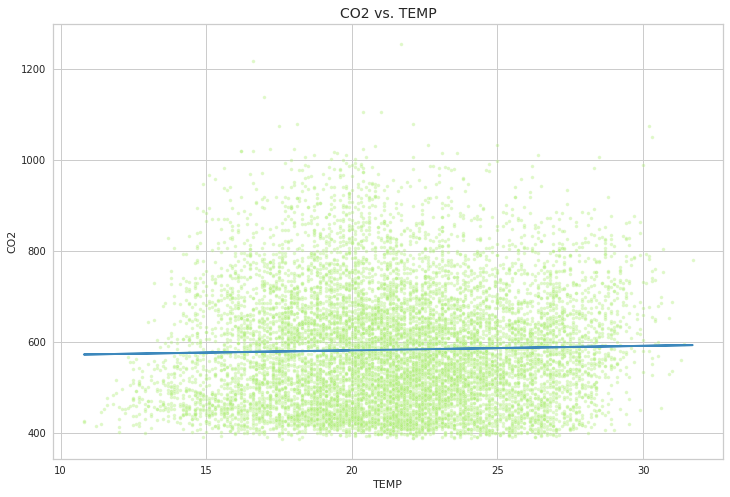

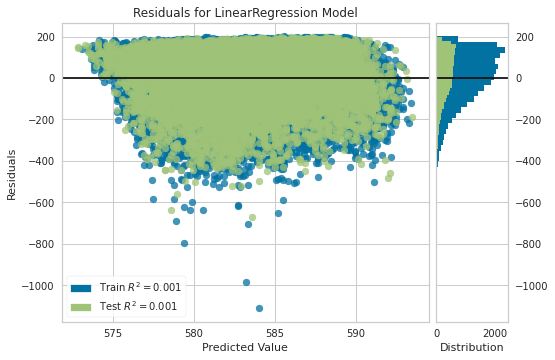

In [ ]:
create_lin_reg(df_chatelet_clean['TEMP'].to_frame(),df_chatelet_clean['CO2'].to_frame())

Slope: [[-2.0481596]]
Intercept: [675.50344936]
Mean squared error: 15810.42
Root mean squared error: 125.74
R2 score:  0.016661593134059238


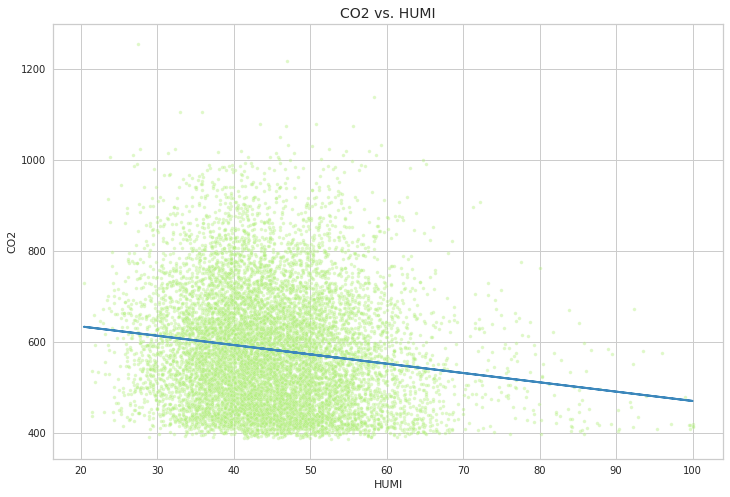

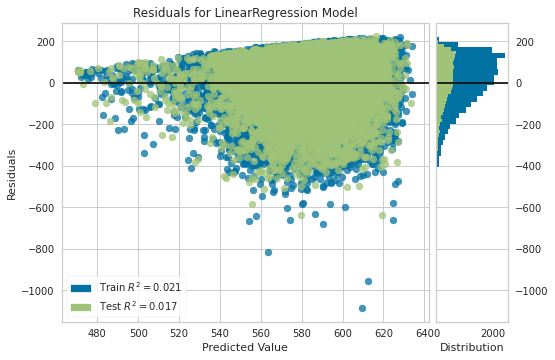

In [ ]:
create_lin_reg(df_chatelet_clean['HUMI'].to_frame(),df_chatelet_clean['CO2'].to_frame())

Slope: [[0.49837487]]
Intercept: [517.05628952]
Mean squared error: 13865.38
Root mean squared error: 117.75
R2 score:  0.13763484524874048


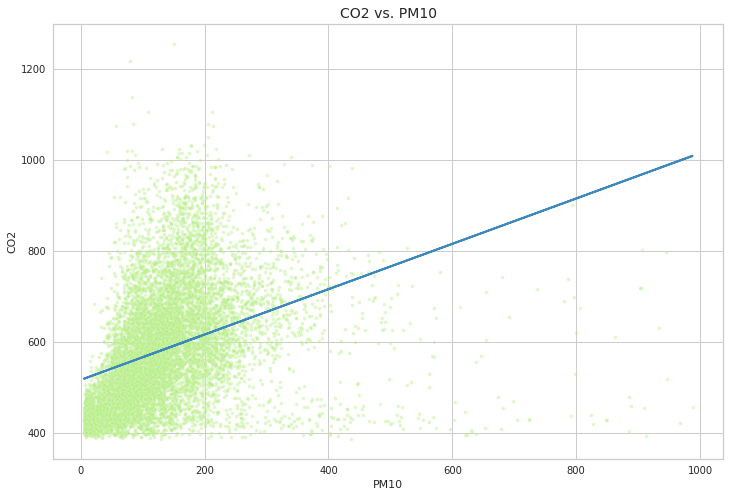

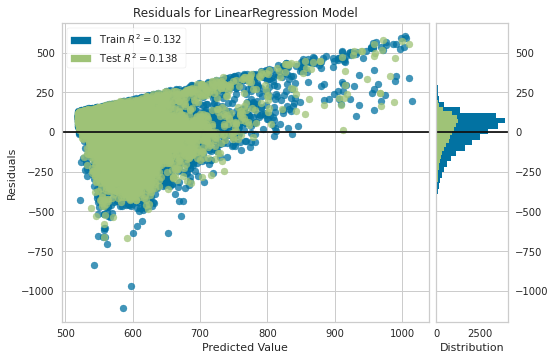

In [ ]:
create_lin_reg(df_chatelet_clean['PM10'].to_frame(),df_chatelet_clean['CO2'].to_frame())

In [ ]:
df_hours = pd.get_dummies(df_chatelet_clean.hour, prefix='hour')
df_hours.head(5)

df_chatelet_clean_dummie = pd.concat([df_chatelet_clean,df_hours], axis=1)

df_chatelet_clean_dummie.head(5)
#df_chatelet_clean_dummie.shape

DATE/HEURE     NO   NO2   PM10    CO2  TEMP  HUMI  hour  \
0  2013-03-04 16:00:00+01:00   38.0  62.0  128.0  777.0  17.2  40.4    16   
1  2013-03-04 20:00:00+01:00   51.0  75.0  136.0  843.0  17.8  44.9    20   
2  2013-03-05 22:00:00+01:00   57.0  70.0  149.0  626.0  19.1  38.5    22   
3  2013-03-06 10:00:00+01:00  171.0  94.0  150.0  800.0  18.5  39.0    10   
4  2013-03-08 21:00:00+01:00   31.0  61.0  105.0  800.0  19.9  54.2    21   

   weekday  weekend  ...  hour_14  hour_15  hour_16  hour_17  hour_18  \
0        0        0  ...        0        0        1        0        0   
1        0        0  ...        0        0        0        0        0   
2        1        0  ...        0        0        0        0        0   
3        2        0  ...        0        0        0        0        0   
4        4        0  ...        0        0        0        0        0   

   hour_19  hour_20  hour_21  hour_22  hour_23  
0        0        0        0        0        0  
1        0        1        0        0        0  
2        0        0        0        1        0  
3        0        0        0        0        0  
4        0        0        1        0        0  

[5 rows x 36 columns]

In [ ]:
X_chatelet = df_chatelet_clean_dummie.drop(columns=['DATE/HEURE','NO','NO2','PM10','CO2','hour','weekday','summer','month','TEMP'])
Y_chatelet = df_chatelet_clean_dummie['CO2']

X_tr_chatelet, X_ts_chatelet, Y_tr_chatelet, Y_ts_chatelet = train_test_split(X_chatelet, Y_chatelet, test_size=0.3, random_state=12)

sc = StandardScaler()
X_tr_chatelet = pd.DataFrame(sc.fit_transform(X_tr_chatelet),columns = X_tr_chatelet.columns)
X_ts_chatelet = pd.DataFrame(sc.fit_transform(X_ts_chatelet),columns = X_ts_chatelet.columns)

X_tr_chatelet.head()

HUMI   weekend    hour_0    hour_1    hour_2    hour_3   hour_4  \
0 -1.140169 -0.630876 -0.217011 -0.211224 -0.204301 -0.193634 -0.18886   
1 -0.708444  1.585098  4.608064 -0.211224 -0.204301 -0.193634 -0.18886   
2 -0.179581 -0.630876 -0.217011 -0.211224 -0.204301 -0.193634 -0.18886   
3  0.781008  1.585098 -0.217011 -0.211224 -0.204301 -0.193634 -0.18886   
4 -0.557340  1.585098 -0.217011 -0.211224 -0.204301 -0.193634 -0.18886   

     hour_5    hour_6    hour_7  ...   hour_14  hour_15   hour_16   hour_17  \
0 -0.184747 -0.190888 -0.202893  ... -0.216151 -0.21423 -0.213554 -0.210344   
1 -0.184747 -0.190888 -0.202893  ... -0.216151 -0.21423 -0.213554 -0.210344   
2 -0.184747 -0.190888  4.928718  ... -0.216151 -0.21423 -0.213554 -0.210344   
3 -0.184747 -0.190888 -0.202893  ... -0.216151 -0.21423 -0.213554 -0.210344   
4 -0.184747 -0.190888 -0.202893  ... -0.216151 -0.21423 -0.213554 -0.210344   

    hour_18   hour_19  hour_20   hour_21   hour_22   hour_23  
0  4.736509 -0.211516 -0.21423 -0.212488 -0.211419 -0.211711  
1 -0.211126 -0.211516 -0.21423 -0.212488 -0.211419 -0.211711  
2 -0.211126 -0.211516 -0.21423 -0.212488 -0.211419 -0.211711  
3 -0.211126 -0.211516 -0.21423 -0.212488 -0.211419 -0.211711  
4 -0.211126 -0.211516 -0.21423 -0.212488 -0.211419 -0.211711  

[5 rows x 26 columns]

In [ ]:
import statsmodels.api as sm
est = sm.OLS(Y_chatelet, X_chatelet)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    CO2   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     2326.
Date:                Thu, 12 Nov 2020   Prob (F-statistic):               0.00
Time:                        08:55:24   Log-Likelihood:            -2.1977e+05
No. Observations:               37831   AIC:                         4.396e+05
Df Residuals:                   37805   BIC:                         4.398e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
HUMI          -1.2944      0.045    -28.636      0.0

In [ ]:
# instantiate the regressor class
regressor = linear_model.Ridge(alpha=.5)

# fit the build the model by fitting the regressor to the training data
regressor.fit(X_tr_chatelet, Y_tr_chatelet)

# make a prediction set using the test set
y_prediction_chatelet = regressor.predict(X_ts_chatelet)


In [ ]:
coeff_df = pd.DataFrame(regressor.coef_, X_chatelet.columns, columns=['Coefficient'])
print(coeff_df)

         Coefficient
HUMI      -12.364507
weekend   -11.279356
hour_0    -10.952872
hour_1    -15.830432
hour_2    -22.541518
hour_3    -25.187266
hour_4    -26.064861
hour_5    -26.004044
hour_6    -25.687610
hour_7    -23.411774
hour_8    -15.437104
hour_9     -1.339277
hour_10     7.339574
hour_11     2.092203
hour_12     1.076509
hour_13     3.997013
hour_14     7.089719
hour_15     9.809509
hour_16    14.833972
hour_17    21.544333
hour_18    33.034935
hour_19    38.236627
hour_20    32.432196
hour_21    16.196361
hour_22    -0.236528
hour_23    -7.523479


In [ ]:
fig_co2_chatelet = px.bar(
    x=X_chatelet.columns, y=regressor.coef_, color=['Positive' if c > 0 else 'Negative' for c in regressor.coef_],
    color_discrete_sequence=['red', 'blue'],
    labels=dict(x='Feature', y='Linear coefficient'),
    title='Weight of selected features for predicting CO2 in Chatelete '
)
fig_co2_chatelet.show()

In [ ]:
coeff_df_ridge = pd.DataFrame(regressor_ridge.coef_, X_chatelet.columns, columns=['Coefficient'])
print(coeff_df_ridge)

         Coefficient
HUMI      -12.364507
weekend   -11.279356
hour_0    -10.952872
hour_1    -15.830432
hour_2    -22.541518
hour_3    -25.187266
hour_4    -26.064861
hour_5    -26.004044
hour_6    -25.687610
hour_7    -23.411774
hour_8    -15.437104
hour_9     -1.339277
hour_10     7.339574
hour_11     2.092203
hour_12     1.076509
hour_13     3.997013
hour_14     7.089719
hour_15     9.809509
hour_16    14.833972
hour_17    21.544333
hour_18    33.034935
hour_19    38.236627
hour_20    32.432196
hour_21    16.196361
hour_22    -0.236528
hour_23    -7.523479


       Actual   Predicted
66850   511.0  550.746560
4106    537.0  545.499927
10243   634.0  587.026989
1773    479.0  498.901880
65903   490.0  619.134630
48196   646.0  613.136764
3332    702.0  745.930141
8186    691.0  597.475453
13679  1093.0  781.726007
55288   766.0  760.717467


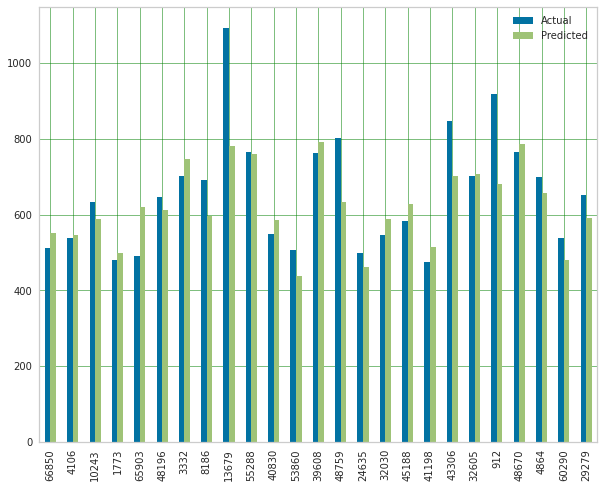

In [ ]:
df_pred_act = pd.DataFrame({'Actual': Y_ts_chatelet, 'Predicted': y_prediction_chatelet})
print(df_pred_act.head(10))

df_pred_act.head(25).plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
# Evaluate the prediction accuracy of the model
print("The Explained Variance: %.2f" % regressor.score(X_ts_chatelet, Y_ts_chatelet))
print("The Mean Absolute Error: %.2f " % mean_absolute_error(Y_ts_chatelet, y_prediction_chatelet))
print("The Median Absolute Error: %.2f " % median_absolute_error(Y_ts_chatelet, y_prediction_chatelet))

The Explained Variance: 0.61
The Mean Absolute Error: 59.29 
The Median Absolute Error: 43.51 


In [ ]:
mse = mean_squared_error(Y_ts_chatelet, y_prediction_chatelet)
r2 = r2_score(Y_ts_chatelet, y_prediction_chatelet)
intercept = regressor.intercept_

print("Mean squared error: %.2f" %mse)
print("Root mean squared error: %.2f" %math.sqrt(mse))
print("Intercept: %.2f" %intercept)
print("R2 Score: %.2f" %r2)

Mean squared error: 6476.08
Root mean squared error: 80.47
Intercept: 582.85
R2 Score: 0.61


In [ ]:
cross_validation(X_chatelet,Y_chatelet)

R_squared Mean Score: 0.5504624594074145
[0.6320214  0.65978689 0.67232853 0.56978435 0.21839113]


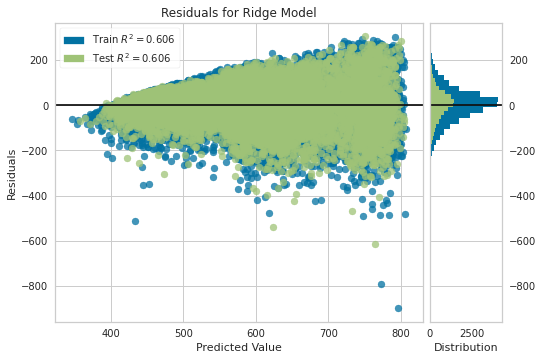

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [ ]:
residu_chatelet_co2 = ResidualsPlot(regressor)

residu_chatelet_co2.fit(X_tr_chatelet, Y_tr_chatelet)  # Fit the training data to the visualizer
residu_chatelet_co2.score(X_ts_chatelet, Y_ts_chatelet)  # Evaluate the model on the test data
residu_chatelet_co2.show()                 # Finalize and render the figure

### 2a. Predict NO2 level in a Chatelet station from past values, temperature and humidity. 

In [ ]:
standarddev = df_chatelet_clean['NO2'].std()
print(standarddev)
standarddev_co2 = df_chatelet_clean['CO2'].std()
print(standarddev_co2)

14.842213290854907
128.5234032908918


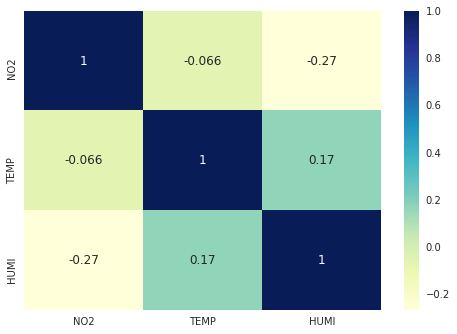

In [ ]:
sns.heatmap(df_chatelet_clean[['NO2','TEMP','HUMI']].corr(), cmap="YlGnBu", annot = True)
plt.show()

Slope: [[-0.2727135]]
Intercept: [42.02886202]
Mean squared error: 222.53
Root mean squared error: 14.92
R2 score:  0.0041396699273298365


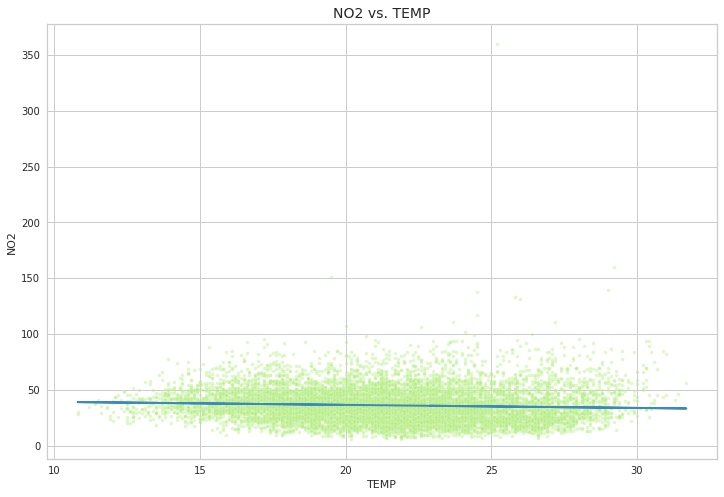

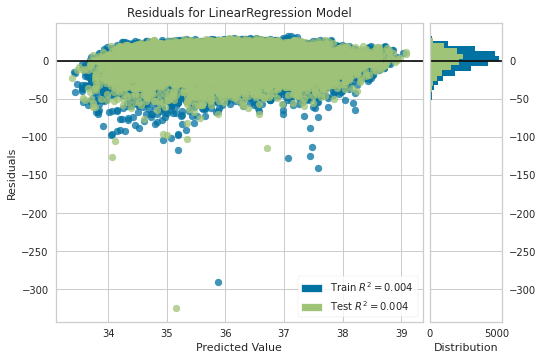

In [ ]:
create_lin_reg(df_chatelet_clean['TEMP'].to_frame(),df_chatelet_clean['NO2'].to_frame())

Slope: [[-0.4316833]]
Intercept: [55.58533228]
Mean squared error: 207.06
Root mean squared error: 14.39
R2 score:  0.07337003373357187


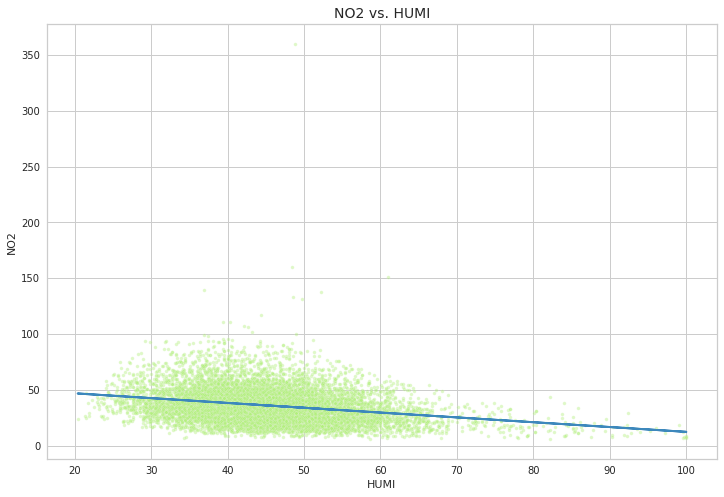

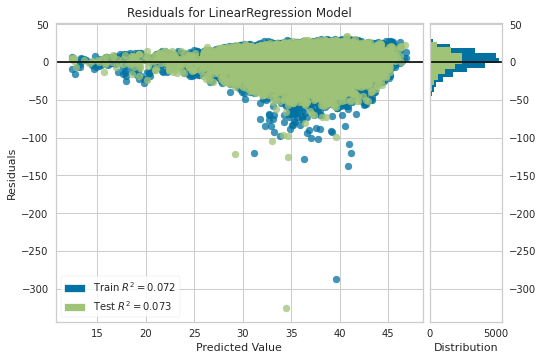

In [ ]:
create_lin_reg(df_chatelet_clean['HUMI'].to_frame(),df_chatelet_clean['NO2'].to_frame())

In [ ]:
X_chatelet_no2 = df_chatelet_clean[['TEMP','HUMI']]
Y_chatelet_no2 = df_chatelet_clean_dummie['NO2']

X_tr_chatelet_no2, X_ts_chatelet_no2, Y_tr_chatelet_no2, Y_ts_chatelet_no2 = train_test_split(X_chatelet_no2, Y_chatelet_no2, test_size=0.3, random_state=42)

sc = StandardScaler()
X_tr_chatelet_no2 = sc.fit_transform(X_tr_chatelet_no2)
X_ts_chatelet_no2 = sc.transform (X_ts_chatelet_no2)

In [ ]:
# instantiate the regressor class
lin_reg_chatelet_no2 = LinearRegression()

# fit the build the model by fitting the regressor to the training data
lin_reg_chatelet_no2.fit(X_tr_chatelet_no2, Y_tr_chatelet_no2)

# make a prediction set using the test set
y_prediction_chatelet_no2 = lin_reg_chatelet_no2.predict(X_ts_chatelet_no2)

In [ ]:
coeff_chatelet_no2 = pd.DataFrame(lin_reg_chatelet_no2.coef_, X_chatelet_no2.columns, columns=['Coefficient'])
print(coeff_chatelet_no2)

      Coefficient
TEMP    -0.326988
HUMI    -3.916301


In [ ]:
fig_no2_chatelet = px.bar(
    x=X_chatelet_no2.columns, y=lin_reg_chatelet_no2.coef_, color=['Positive' if c > 0 else 'Negative' for c in lin_reg_chatelet_no2.coef_],
    color_discrete_sequence=['red', 'blue'],
    labels=dict(x='Feature', y='Linear coefficient'),
    title='Weight of selected features for predicting NO2 in Chatelete '
)
fig_no2_chatelet.show()

       Actual  Predicted
12291    58.0  32.512929
7501     57.0  38.186154
44086    41.0  39.777996
54834    30.0  40.274653
68220    73.0  35.992092
37955    54.0  39.322591
40492    21.0  33.016043
59291    59.0  34.097195
1718     14.0  32.382720
9979     31.0  36.549305


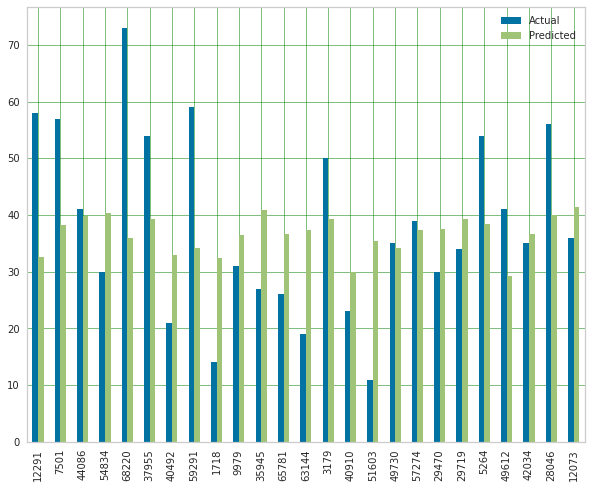

In [ ]:
df_pred_act_chatelet_no2 = pd.DataFrame({'Actual': Y_ts_chatelet_no2, 'Predicted': y_prediction_chatelet_no2})
print(df_pred_act_chatelet_no2.head(10))

df_pred_act_chatelet_no2.head(25).plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
# Evaluate the prediction accuracy of the model
print("The Explained Variance: %.2f" % lin_reg_chatelet_no2.score(X_ts_chatelet_no2, Y_ts_chatelet_no2))
print("The Mean Absolute Error: %.2f " % mean_absolute_error(Y_ts_chatelet_no2, y_prediction_chatelet_no2))
print("The Median Absolute Error: %.2f " % median_absolute_error(Y_ts_chatelet_no2, y_prediction_chatelet_no2))

The Explained Variance: 0.07
The Mean Absolute Error: 10.81 
The Median Absolute Error: 8.85 


In [ ]:
mse_no2 = mean_squared_error(Y_ts_chatelet_no2, y_prediction_chatelet_no2)
rmse_no2 = math.sqrt(mse_no2)
r2_no2 = r2_score(Y_ts_chatelet_no2, y_prediction_chatelet_no2)
intercept_no2 = lin_reg_chatelet_no2.intercept_

print("Mean squared error: %.2f" %mse_no2)
print("Root mean squared error: %.2f" %rmse_no2)
print("Intercept: %.2f" %intercept_no2)
print("R2 Score: %.2f" %r2_no2)

Mean squared error: 206.98
Root mean squared error: 14.39
Intercept: 36.17
R2 Score: 0.07


In [ ]:
cross_validation(X_chatelet_no2,Y_chatelet_no2)

R_squared Mean Score: 0.0465723949977199
[0.03293397 0.0387159  0.03398604 0.06971274 0.05751332]


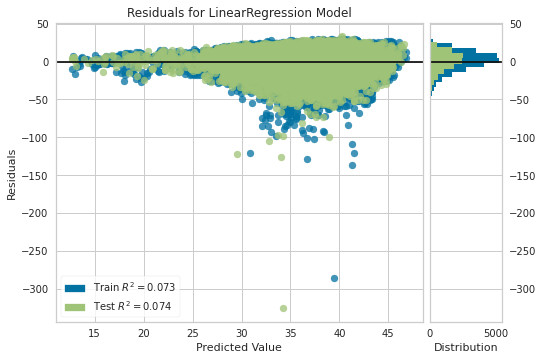

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [ ]:
residu_chatelet_no2 = ResidualsPlot(lin_reg_chatelet_no2)

residu_chatelet_no2.fit(X_tr_chatelet_no2, Y_tr_chatelet_no2)  # Fit the training data to the visualizer
residu_chatelet_no2.score(X_ts_chatelet_no2, Y_ts_chatelet_no2)  # Evaluate the model on the test data
residu_chatelet_no2.show()                 # Finalize and render the figure

### 2b. Model with CO2 level and comparison

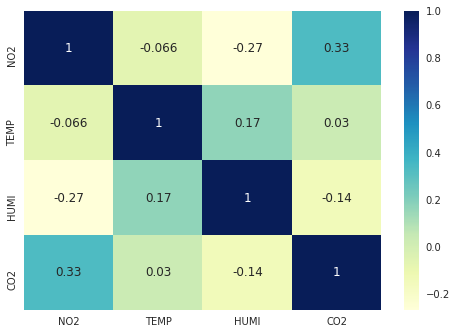

In [ ]:
sns.heatmap(df_chatelet_clean[['NO2','TEMP','HUMI','CO2']].corr(), cmap="YlGnBu", annot = True)
plt.show()

Slope: [[0.03820703]]
Intercept: [13.883543]
Mean squared error: 198.11
Root mean squared error: 14.08
R2 score:  0.11340893020649156


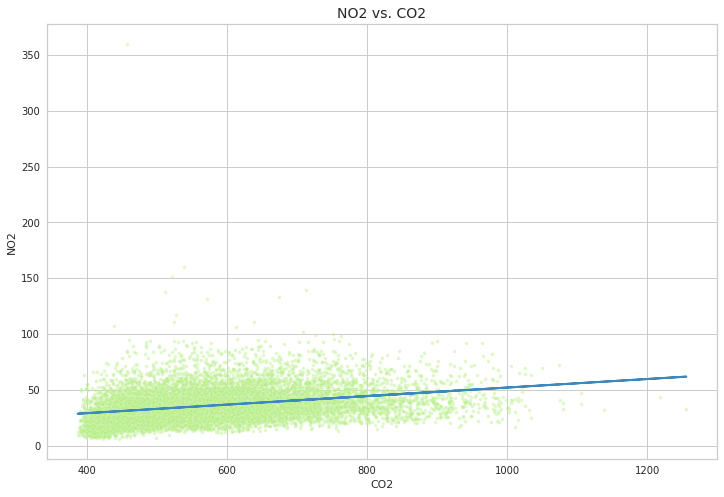

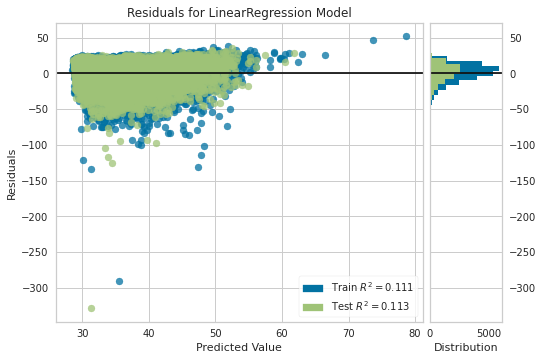

In [ ]:
create_lin_reg(df_chatelet_clean['CO2'].to_frame(),df_chatelet_clean['NO2'].to_frame())

In [ ]:
X_chatelet_no2_co2 = df_chatelet_clean[['TEMP','HUMI','CO2']]
Y_chatelet_no2_co2 = df_chatelet_clean['NO2']
X_tr_chatelet_no2_co2, X_ts_chatelet_no2_co2, Y_tr_chatelet_no2_co2, Y_ts_chatelet_no2_co2 = train_test_split(X_chatelet_no2_co2, Y_chatelet_no2_co2, test_size=0.3, random_state=12)

In [ ]:
# instantiate the regressor class
regressor_co2 = LinearRegression()

# fit the build the model by fitting the regressor to the training data
regressor_co2.fit(X_tr_chatelet_no2_co2, Y_tr_chatelet_no2_co2)

# make a prediction set using the test set
y_prediction_chatelet_no2_co2 = regressor_co2.predict(X_ts_chatelet_no2_co2)

In [ ]:
coeff_df_co2 = pd.DataFrame(regressor_co2.coef_, X_chatelet_no2_co2.columns, columns=['Coefficient'])
print(coeff_df_co2)

      Coefficient
TEMP    -0.142499
HUMI    -0.355128
CO2      0.034862


       Actual  Predicted
66850    47.0  32.677230
4106     24.0  31.714136
10243    33.0  37.901456
1773     16.0  29.389257
65903    25.0  30.915935
48196    49.0  39.736656
3332     21.0  38.783200
8186     39.0  32.319569
13679    37.0  54.806159
55288    39.0  45.184046


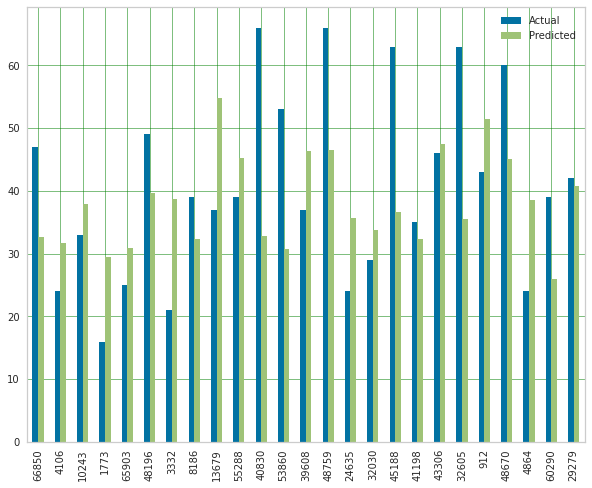

In [ ]:
df_pred_act_no2_co2 = pd.DataFrame({'Actual': Y_ts_chatelet_no2_co2, 'Predicted': y_prediction_chatelet_no2_co2})
print(df_pred_act_no2_co2.head(10))

df_pred_act_no2_co2.head(25).plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
# Evaluate the prediction accuracy of the model
print("The Explained Variance: %.2f" % regressor_co2.score(X_ts_chatelet_no2_co2, Y_ts_chatelet_no2_co2))
print("The Mean Absolute Error: %.2f " % mean_absolute_error(Y_ts_chatelet_no2_co2, y_prediction_chatelet_no2_co2))
print("The Median Absolute Error: %.2f " % median_absolute_error(Y_ts_chatelet_no2_co2, y_prediction_chatelet_no2_co2))

The Explained Variance: 0.17
The Mean Absolute Error: 10.05 
The Median Absolute Error: 8.43 


In [ ]:
mse = mean_squared_error(Y_ts_chatelet_no2_co2, y_prediction_chatelet_no2_co2)
rmse =  math.sqrt(mse)
r2 = r2_score(Y_ts_chatelet_no2_co2, y_prediction_chatelet_no2_co2)
print(mse)
print(r2)
print(rmse)

172.4728241360285
0.17175378549853715
13.132890928353456


In [ ]:
cross_validation(X_chatelet_no2_co2,Y_chatelet_no2_co2)

R_squared Mean Score: 0.1400101747347392
[0.14918454 0.15996116 0.11576475 0.13763649 0.13750393]


### 3 Compare models for each stations

In [ ]:
X_chatelet_co2 = df_chatelet_clean[['TEMP','HUMI', 'weekend', 'NO', 'NO2','PM10']]
Y_chatelet_co2 = df_chatelet_clean['CO2']
X_tr_chatelet_co2, X_ts_chatelet_co2, Y_tr_chatelet_co2, Y_ts_chatelet_co2 = train_test_split(X_chatelet_co2, Y_chatelet_co2, test_size=0.3, random_state=12)

df_roosevelt_clean = df_roosevelt.dropna()
X_roosevelt_co2 = df_roosevelt_clean[['TEMP','HUMI', 'weekend', 'NO', 'NO2','PM10']]
Y_roosevelt_co2 = df_roosevelt_clean['CO2']
X_tr_roosevelt_co2, X_ts_roosevelt_co2, Y_tr_roosevelt_co2, Y_ts_roosevelt_co2 = train_test_split(X_roosevelt_co2, Y_roosevelt_co2, test_size=0.3, random_state=12)

df_auber_clean = df_auber.dropna()
X_auber_co2 = df_auber_clean[['TEMP','HUMI', 'weekend', 'NO', 'NO2','PM10']]
Y_auber_co2 = df_auber_clean['CO2']
X_tr_auber_co2, X_ts_auber_co2, Y_tr_auber_co2, Y_ts_auber_co2 = train_test_split(X_auber_co2, Y_auber_co2, test_size=0.3, random_state=12)

In [ ]:
# instantiate the regressor class
regressor_co2_c = LinearRegression()
regressor_co2_a = LinearRegression()
regressor_co2_r = LinearRegression()

# fit the build the models by fitting the regressor to the training data
regressor_co2_c.fit(X_tr_chatelet_co2, Y_tr_chatelet_co2)
regressor_co2_a.fit(X_tr_auber_co2, Y_tr_auber_co2)
regressor_co2_r.fit(X_tr_roosevelt_co2, Y_tr_roosevelt_co2)

# make a prediction set using the test set
y_prediction_chatelet_co2 = regressor_co2_c.predict(X_ts_chatelet_co2)
y_prediction_auber_co2 = regressor_co2_c.predict(X_ts_auber_co2)
y_prediction_roosevelt_co2 = regressor_co2_r.predict(X_ts_roosevelt_co2)

In [ ]:
# Evaluate the prediction accuracy of the model
print("          The Explained Variance    The Mean Absolute Error    The Median Absolute Error")
print("Chatelet  %.2f" %  regressor_co2_c.score(X_ts_chatelet_co2, Y_ts_chatelet_co2),"                     %.2f" %  mean_absolute_error(Y_ts_chatelet_co2, y_prediction_chatelet_co2),"                     %.2f" %  median_absolute_error(Y_ts_chatelet_co2, y_prediction_chatelet_co2))
print("Auber     %.2f " %  regressor_co2_a.score(X_ts_auber_co2, Y_ts_auber_co2),"                    %.2f" %  mean_absolute_error(Y_ts_auber_co2, y_prediction_auber_co2),"                    %.2f" %  median_absolute_error(Y_ts_auber_co2, y_prediction_auber_co2))
print("Roosevelt %.2f " %  regressor_co2_r.score(X_ts_roosevelt_co2, Y_ts_roosevelt_co2),"                    %.2f" %  mean_absolute_error(Y_ts_roosevelt_co2, y_prediction_roosevelt_co2),"                     %.2f" %  median_absolute_error(Y_ts_chatelet_co2, y_prediction_chatelet_co2))


          The Explained Variance    The Mean Absolute Error    The Median Absolute Error
Chatelet  0.24                      85.72                      70.22
Auber     0.31                      114.31                     108.79
Roosevelt 0.43                      33.20                      70.22


In [ ]:
print("          Root Mean Squared Error     R2 score ")
print("Chatelet  %.2f" %   math.sqrt(mean_squared_error(Y_ts_chatelet_co2, y_prediction_chatelet_co2)),"                     %.2f" %  r2_score(Y_ts_chatelet_co2, y_prediction_chatelet_co2))
print("Auber     %.2f" %   math.sqrt(mean_squared_error(Y_ts_auber_co2, y_prediction_auber_co2)),"                    %.2f" %  r2_score(Y_ts_auber_co2, y_prediction_auber_co2))
print("Roosevelt %.2f" %   math.sqrt(mean_squared_error(Y_ts_roosevelt_co2, y_prediction_roosevelt_co2)),"                      %.2f" %  r2_score(Y_ts_roosevelt_co2, y_prediction_roosevelt_co2))


          Root Mean Squared Error     R2 score 
Chatelet  112.16                      0.24
Auber     137.08                     -0.62
Roosevelt 44.59                       0.43


In [ ]:
data = {'The Explained Variance':  [0.24, 0.31, 0.43],
        'The Mean Absolute Error': [85.72, 114.31, 33.20],
        'The Median Absolute Error': [70.22, 108.79, 70.22],
        'Mean Squared Error': [12579.38, 18791.71, 1988.01],
        'R2 score': [0.24, -0.62,  0.43],
        }   

In [ ]:
df = pd.DataFrame(data, columns=['The Explained Variance', 'The Mean Absolute Error', 'The Median Absolute Error', 'Mean Squared Error', 'R2 score' ], index=['Chatelet', 'Auber ', 'Roosevelt'] )
df

The Explained Variance  The Mean Absolute Error  \
Chatelet                     0.24                    85.72   
Auber                        0.31                   114.31   
Roosevelt                    0.43                    33.20   

           The Median Absolute Error  Mean Squared Error  R2 score  
Chatelet                       70.22            12579.38      0.24  
Auber                         108.79            18791.71     -0.62  
Roosevelt                      70.22             1988.01      0.43

In [ ]:
cross_validation(X_chatelet_co2,Y_chatelet_co2)
cross_validation(X_auber_co2,Y_auber_co2)
cross_validation(X_roosevelt_co2,Y_roosevelt_co2)

R_squared Mean Score: 0.20668991804863576
[0.22314336 0.2210597  0.2071278  0.17193774 0.21018098]
R_squared Mean Score: 0.3005793552788618
[0.32219131 0.25688093 0.32405216 0.30568836 0.29408401]
R_squared Mean Score: 0.4064783289103361
[0.42968873 0.46535062 0.45711333 0.39779463 0.28244433]


In [ ]:
X_chatelet_co2 = df_chatelet_clean[['TEMP','HUMI', 'weekend', 'NO', 'CO2','PM10']]
Y_chatelet_co2 = df_chatelet_clean['NO2']
X_tr_chatelet_co2, X_ts_chatelet_co2, Y_tr_chatelet_co2, Y_ts_chatelet_co2 = train_test_split(X_chatelet_co2, Y_chatelet_co2, test_size=0.3, random_state=12)

df_roosevelt_clean = df_roosevelt.dropna()
X_roosevelt_co2 = df_roosevelt_clean[['TEMP','HUMI', 'weekend', 'NO', 'CO2','PM10']]
Y_roosevelt_co2 = df_roosevelt_clean['NO2']
X_tr_roosevelt_co2, X_ts_roosevelt_co2, Y_tr_roosevelt_co2, Y_ts_roosevelt_co2 = train_test_split(X_roosevelt_co2, Y_roosevelt_co2, test_size=0.3, random_state=12)

df_auber_clean = df_auber.dropna()
X_auber_co2 = df_auber_clean[['TEMP','HUMI', 'weekend', 'NO', 'CO2','PM10']]
Y_auber_co2 = df_auber_clean['NO2']
X_tr_auber_co2, X_ts_auber_co2, Y_tr_auber_co2, Y_ts_auber_co2 = train_test_split(X_auber_co2, Y_auber_co2, test_size=0.3, random_state=12)

In [ ]:
# instantiate the regressor class
regressor_co2_c = LinearRegression()
regressor_co2_a = LinearRegression()
regressor_co2_r = LinearRegression()

# fit the build the models by fitting the regressor to the training data
regressor_co2_c.fit(X_tr_chatelet_co2, Y_tr_chatelet_co2)
regressor_co2_a.fit(X_tr_auber_co2, Y_tr_auber_co2)
regressor_co2_r.fit(X_tr_roosevelt_co2, Y_tr_roosevelt_co2)

# make a prediction set using the test set
y_prediction_chatelet_co2 = regressor_co2_c.predict(X_ts_chatelet_co2)
y_prediction_auber_co2 = regressor_co2_c.predict(X_ts_auber_co2)
y_prediction_roosevelt_co2 = regressor_co2_r.predict(X_ts_roosevelt_co2)

In [ ]:
# Evaluate the prediction accuracy of the model
print("          The Explained Variance    The Mean Absolute Error    The Median Absolute Error")
print("Chatelet  %.2f" %  regressor_co2_c.score(X_ts_chatelet_co2, Y_ts_chatelet_co2),"                     %.2f" %  mean_absolute_error(Y_ts_chatelet_co2, y_prediction_chatelet_co2),"                     %.2f" %  median_absolute_error(Y_ts_chatelet_co2, y_prediction_chatelet_co2))
print("Auber     %.2f " %  regressor_co2_a.score(X_ts_auber_co2, Y_ts_auber_co2),"                    %.2f" %  mean_absolute_error(Y_ts_auber_co2, y_prediction_auber_co2),"                    %.2f" %  median_absolute_error(Y_ts_auber_co2, y_prediction_auber_co2))
print("Roosevelt %.2f " %  regressor_co2_r.score(X_ts_roosevelt_co2, Y_ts_roosevelt_co2),"                    %.2f" %  mean_absolute_error(Y_ts_roosevelt_co2, y_prediction_roosevelt_co2),"                     %.2f" %  median_absolute_error(Y_ts_chatelet_co2, y_prediction_chatelet_co2))


          The Explained Variance    The Mean Absolute Error    The Median Absolute Error
Chatelet  0.32                      9.16                      7.65
Auber     0.38                      15.75                     12.75
Roosevelt 0.38                      13.20                      7.65


In [ ]:
print("          Root Mean Squared Error     R2 score ")
print("Chatelet  %.2f" %   math.sqrt(mean_squared_error(Y_ts_chatelet_co2, y_prediction_chatelet_co2)),"                     %.2f" %  r2_score(Y_ts_chatelet_co2, y_prediction_chatelet_co2))
print("Auber     %.2f" %   math.sqrt(mean_squared_error(Y_ts_auber_co2, y_prediction_auber_co2)),"                    %.2f" %  r2_score(Y_ts_auber_co2, y_prediction_auber_co2))
print("Roosevelt %.2f" %   math.sqrt(mean_squared_error(Y_ts_roosevelt_co2, y_prediction_roosevelt_co2)),"                      %.2f" %  r2_score(Y_ts_roosevelt_co2, y_prediction_roosevelt_co2))


          Root Mean Squared Error     R2 score 
Chatelet  11.92                      0.32
Auber     21.23                     -0.10
Roosevelt 17.23                       0.38


In [ ]:
cross_validation(X_chatelet_co2,Y_chatelet_co2)
cross_validation(X_auber_co2,Y_auber_co2)
cross_validation(X_roosevelt_co2,Y_roosevelt_co2)

R_squared Mean Score: 0.30147809398835246
[0.29175331 0.30488337 0.27180643 0.30830149 0.33064587]
R_squared Mean Score: 0.37863524561694967
[0.37868175 0.37568319 0.32578533 0.40533442 0.40769154]
R_squared Mean Score: 0.35350023423277943
[0.36807663 0.32967998 0.307418   0.39055361 0.37177296]


### 4. Based on data from two stations, can we predict air quality in the third one ?

### 4.1 Preparing our dataset

Merge all the features (initial + engineered) for the first two stations: Chatelet and Auber

In [ ]:
indexNames = df_chatelet[ df_chatelet['CO2'] > 2000 ].index
df_chatelet_temp = df_chatelet.drop(indexNames)

#merge by inner join (intersection) on 'DATE/HEURE'
left = df_chatelet_temp.copy()
duplicates = ['hour', 'weekday', 'weekend', 'month', 'summer']
left.drop(duplicates, axis=1, inplace=True)

right = df_auber.copy()

pd_all_stations = pd.merge(left, right, how='inner', on='DATE/HEURE')

#examine the resulting DataFrame just as a sanity check
pd_all_stations.head(5)

DATE/HEURE   NO_x  NO2_x  PM10_x  CO2_x  TEMP_x  HUMI_x  \
0  2013-03-04 16:00:00+01:00   38.0   62.0   128.0  777.0    17.2    40.4   
1  2013-03-04 20:00:00+01:00   51.0   75.0   136.0  843.0    17.8    44.9   
2  2013-03-05 22:00:00+01:00   57.0   70.0   149.0  626.0    19.1    38.5   
3  2013-03-06 10:00:00+01:00  171.0   94.0   150.0  800.0    18.5    39.0   
4  2013-03-08 21:00:00+01:00   31.0   61.0   105.0  800.0    19.9    54.2   

    NO_y  NO2_y  PM10_y  PM2.5  CO2_y  TEMP_y  HUMI_y  hour  weekday  weekend  \
0    NaN    NaN   287.0  104.0    NaN    18.2    44.8    16        0        0   
1  193.0   90.0   388.0  136.0  852.0    19.2    47.3    20        0        0   
2   64.0   58.0   373.0  127.0  576.0    19.9    45.9    22        1        0   
3  189.0   63.0   572.0  211.0  851.0    20.1    46.9    10        2        0   
4   50.0   60.0   212.0   66.0  600.0    20.5    51.4    21        4        0   

   month  summer  
0      3       0  
1      3       0  
2      3       0  
3      3       0  
4      3       0

In [ ]:
#this will be our dependent variable 
y_roosevelt = df_roosevelt[['DATE/HEURE','CO2']].copy()

#merge the two stations with our dependent variable, so that the 
#inner join selects only those 'DATE/HEURE' common to all three stations
pd_all_stations = pd.merge(pd_all_stations, y_roosevelt, how='inner', on='DATE/HEURE')

#sanity check
pd_all_stations.sort_values(by=['DATE/HEURE']).head(5)

DATE/HEURE  NO_x  NO2_x  PM10_x  CO2_x  TEMP_x  HUMI_x  \
1033   2013-01-01 02:00:00+01:00   6.0   31.0   182.0  776.0    21.5    46.2   
26097  2013-01-01 03:00:00+01:00   6.0   30.0   166.0  800.0    21.6    47.3   
34969  2013-01-01 04:00:00+01:00   4.0   27.0   124.0  799.0    21.8    47.0   
26101  2013-01-01 05:00:00+01:00   3.0   25.0    85.0  715.0    21.6    45.8   
46735  2013-01-01 06:00:00+01:00   4.0   26.0   102.0  622.0    21.2    45.9   

       NO_y  NO2_y  PM10_y  PM2.5  CO2_y  TEMP_y  HUMI_y  hour  weekday  \
1033    NaN    NaN   243.0   96.0  465.0    20.5    50.6     2        1   
26097   NaN    NaN   141.0   55.0  434.0    20.3    50.4     3        1   
34969   NaN    NaN   157.0   62.0  425.0    20.1    50.4     4        1   
26101   NaN    NaN   134.0   52.0  405.0    20.2    50.5     5        1   
46735   NaN    NaN   133.0   48.0  398.0    20.1    50.2     6        1   

       weekend  month  summer    CO2  
1033         0      1       0  612.0  
26097        0      1       0  536.0  
34969        0      1       0  490.0  
26101        0      1       0  481.0  
46735        0      1       0  464.0

Examine missing data

<AxesSubplot:>

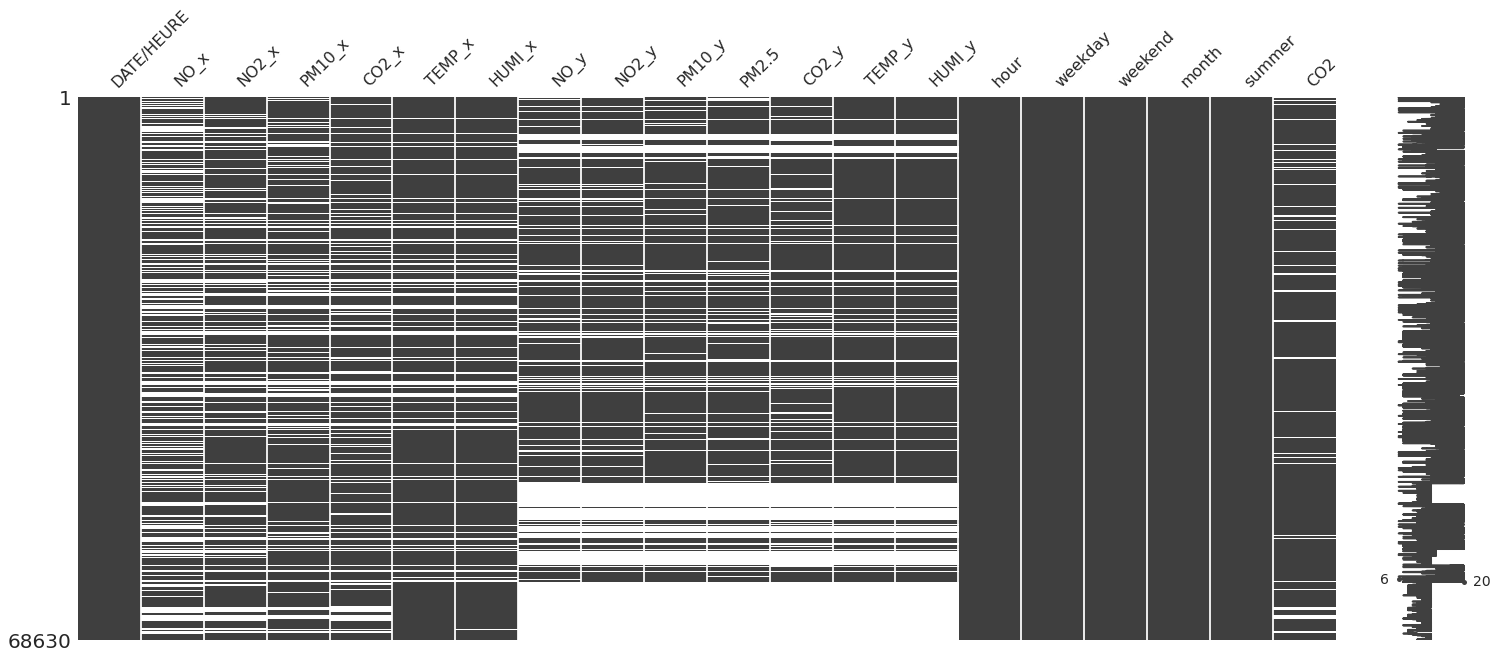

In [ ]:
msno.matrix(pd_all_stations)

We remove all rows with at least one missing value.  
From ~68.000 entries, we are left with ~20.000

In [ ]:
pd_all_stations.columns

Index(['DATE/HEURE', 'NO_x', 'NO2_x', 'PM10_x', 'CO2_x', 'TEMP_x', 'HUMI_x',
       'NO_y', 'NO2_y', 'PM10_y', 'PM2.5', 'CO2_y', 'TEMP_y', 'HUMI_y', 'hour',
       'weekday', 'weekend', 'month', 'summer', 'CO2'],
      dtype='object')

In [ ]:
#how much data are we left with if we drop all rows with at least one missing value for a feature
len(pd_all_stations.dropna(axis=0, how='any'))

20181

In [ ]:
pd_all_stations_clean = pd_all_stations.dropna(axis=0, how='any').copy()
pd_all_stations_clean.drop('DATE/HEURE', axis=1, inplace=True)

Examine outliers

Text(0.5, 1.0, 'Box plots for CO2, NO, NO2, PM10 - Chatelet dataset')

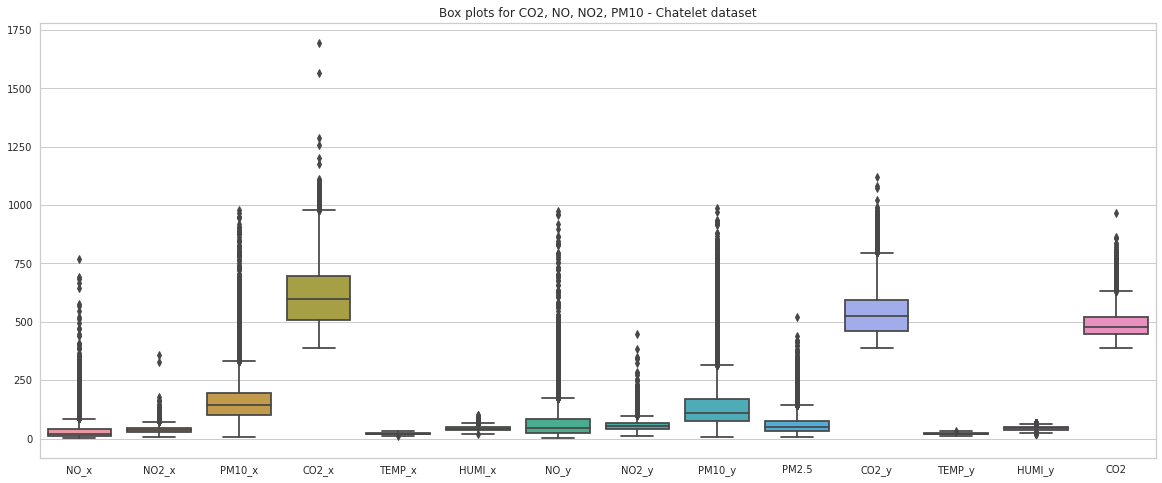

In [ ]:
plt.figure(figsize=(20,8))
sns.boxplot(data=pd_all_stations_clean[['NO_x', 'NO2_x', 'PM10_x', 'CO2_x', 'TEMP_x', 'HUMI_x', 'NO_y', 'NO2_y', 'PM10_y', 'PM2.5', 
    'CO2_y', 'TEMP_y', 'HUMI_y', 'CO2']])
plt.title('Box plots for CO2, NO, NO2, PM10 - Chatelet dataset')

Observations:  
- temperature and humidity need a plot of their own, as they're on a different scale
- we clearly spot some outliers in NO2_x, CO2_x etc. We will examine the influence of NO2_x outliers on linear regression for CO2

## Effect of outliers when predicting CO2 from NO2_x

In [ ]:
#Ordinary Least Square (OLS) 
#x = temp.columns[temp.columns.map(lambda x: 'hour_x' in x)].tolist()
fig = px.scatter(
    pd_all_stations_clean, x='NO2_x', y='CO2', opacity=0.65,
    trendline='ols', trendline_color_override='darkblue', title='Ordinary Least Squares (OLS) regression trendline'
)
fig.update_layout(
    autosize=False,
    width=600,
    height=400,
    xaxis=dict(
        title_text="NO2 Chatelet",
        range=[0, 400]
    ),
    yaxis=dict(
        title_text="CO2 F.R.",
        range=[350, 1000]
        #ticktext=["Very long label", "long label", "3", "label"],
        #tickvals=[1, 2, 3, 4],
        #tickmode="array",
        #titlefont=dict(size=30),
    )
)

fig.show()

In [ ]:
#Ordinary Least Square (OLS) 
#x = temp.columns[temp.columns.map(lambda x: 'hour_x' in x)].tolist()
fig = px.scatter(
    pd_all_stations_clean[pd_all_stations_clean.NO2_x<300], x='NO2_x', y='CO2', opacity=0.65,
    trendline='ols', trendline_color_override='darkblue', title='OLS regression trendline - NO2 outliers removed'
)
fig.update_layout(
    autosize=False,
    width=600,
    height=400,
    xaxis=dict(
        title_text="NO2 Chatelet",
        range=[0, 400]
    ),
    yaxis=dict(
        title_text="CO2 F.R.",
        range=[350, 1000]
        #ticktext=["Very long label", "long label", "3", "label"],
        #tickvals=[1, 2, 3, 4],
        #tickmode="array",
        #titlefont=dict(size=30),
    )
)

fig.show()

Observation:  
We see thus that the few NO2 outliers in Chatelet don't influence the fitted regression line, so we don't mind outliers anymore. They are too few to influence us. 

## Scaling continuous variables

In [ ]:
cols_scale = ['NO_x', 'NO2_x', 'PM10_x', 'CO2_x', 'TEMP_x', 'HUMI_x', 'NO_y', 'NO2_y', 'PM10_y', 'PM2.5', 'CO2_y', 'TEMP_y', 'HUMI_y']

scaler = StandardScaler()
scaler.fit(pd_all_stations_clean[cols_scale])

df_cont_scld = pd.DataFrame(data=scaler.transform(pd_all_stations_clean[cols_scale]), columns=cols_scale)

## One-hot-encoding and scaling (both continuous and dummy)

Scaling dummy variables (otherwise we get humongous coefficients for them)  
['hour', 'weekday', 'weekend', 'month', 'summer']

In [ ]:
cols_dummify = ['hour','weekday','weekend','month','summer']

dep = pd.DataFrame(data=pd_all_stations_clean.CO2.values.reshape(-1,1), columns=["CO2"])
temp = pd_all_stations_clean.drop('CO2', axis=1).copy()

df_dc = pd.get_dummies(temp, columns=cols_dummify, drop_first=True)

scaler = StandardScaler().fit(df_dc)

indep = pd.DataFrame(data=scaler.transform(df_dc), columns=df_dc.columns)
print(indep.shape)
print(dep.shape)

(20181, 55)
(20181, 1)


In [ ]:
pd_all_stations_clean_scld = pd.concat([indep,dep], axis=1)
print(pd_all_stations_clean_scld.shape)

(20181, 56)


In [ ]:
pd_all_stations_clean_scld.head(3)

NO_x     NO2_x    PM10_x     CO2_x    TEMP_x    HUMI_x      NO_y  \
0  0.477646  2.486682 -0.230864  1.748174 -1.115377  0.160637  2.016104   
1  0.630552  2.150620 -0.089069  0.112599 -0.744078 -0.573117  0.033164   
2  3.535766  3.763719 -0.078162  1.424074 -0.915447 -0.515792  1.954618   

      NO2_y    PM10_y     PM2.5  ...   month_5   month_6   month_7   month_8  \
0  1.739118  2.171510  1.588638  ... -0.262828 -0.289643 -0.283569 -0.176397   
1  0.125292  2.039461  1.395083  ... -0.262828 -0.289643 -0.283569 -0.176397   
2  0.377452  3.791312  3.201595  ... -0.262828 -0.289643 -0.283569 -0.176397   

    month_9  month_10  month_11  month_12  summer_1    CO2  
0 -0.333966 -0.356091 -0.347284 -0.232149 -0.471697  559.0  
1 -0.333966 -0.356091 -0.347284 -0.232149 -0.471697  494.0  
2 -0.333966 -0.356091 -0.347284 -0.232149 -0.471697  575.0  

[3 rows x 56 columns]

How many features do we have now ?

In [ ]:
len(pd_all_stations_clean_scld.columns)

56

## Train test split (70-30)

In [ ]:
X = pd_all_stations_clean_scld.drop('CO2', axis=1).copy()
y = pd_all_stations_clean_scld['CO2'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Train a linear regression model using all our features

In [ ]:
lr_all_stations_full = LinearRegression()  
lr_all_stations_full.fit(X_train, y_train) #training the algorithm

y_pred = lr_all_stations_full.predict(X_test)

Since we have more than 2 features, we need some alternative ways to visualize our model.

## Visualizing coefficients

In [ ]:
print('Intercept:',lr_all_stations_full.intercept_)
print('Linear coefficients:', lr_all_stations_full.coef_)


colors = ['Positive' if c > 0 else 'Negative' for c in lr_all_stations_full.coef_]

fig = px.bar(
    x=X.columns, y=lr_all_stations_full.coef_, color=colors,
    color_discrete_sequence=['red', 'blue'],
    labels=dict(x='Feature', y='Linear coefficient'),
    title='Weight of each feature for predicting CO2 in F.R. station'
)
'''
fig.update_layout(
    autosize=False,
    width=1200,
    height=700,
)'''

fig.show()

Intercept: 490.5661209705784
Linear coefficients: [ 3.78135953e+00  6.89291189e+00 -2.71509392e+00  1.35812459e+01
 -8.93452287e+00 -2.37908431e-01  2.98225131e+00  4.45902847e+00
  3.63827423e+00 -1.06278765e+01  2.33331488e+01 -8.86364736e+00
  5.26345782e+00 -1.24121178e+00 -3.23800647e+00 -3.73262685e+00
 -3.38356471e+00 -3.55889417e+00 -3.43290453e+00 -2.74588539e+00
 -4.71605781e+00 -1.78906579e+00  2.10463088e+00 -2.16148101e+00
 -3.43691484e+00 -1.68729524e+00 -1.86961170e+00  2.96503849e-01
  2.06450216e-01  6.65874614e-01  1.49780280e+00  3.69109016e+00
  3.15887322e+00 -7.47394086e-03 -6.98087289e-01 -2.57196163e-02
  3.96512854e-01  7.64264922e-01  1.15976689e+00  1.41492378e+00
  9.28397233e+11  9.08220393e+11 -1.18492778e+12 -4.58428979e-01
  4.67137811e-01  7.46000222e+00  6.59156865e+00  1.83575924e+13
  1.80305432e+13  1.17523112e+13  7.57519967e+00  7.83821479e+00
  5.90789557e+00  6.58174945e+00 -2.65066429e+13]


Observations:  
- The model trained on data containing continuous variables and dummy variables, all standardized, has largely disproportionate coefficients
- Presumably, standardizing the dummy variale was supposed to prevent this behaviors
- Next we will try Ridge:  
    "Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients with l2 regularization."

## Ridge regularization to prevent the large coefficients

In [ ]:
from sklearn import linear_model

reg = linear_model.Ridge(alpha=.5)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

# Evaluate the prediction accuracy of the model
print("The Explained Variance: %.2f" % reg.score(X_test, y_test))
print("The Mean Absolute Error: %.2f " % mean_absolute_error(y_test, y_pred))
print("The Median Absolute Error: %.2f " % median_absolute_error(y_test, y_pred))

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
intercept = reg.intercept_

print("Mean squared error: %.2f" %mse)
print("Root mean squared error: %.2f" %math.sqrt(mse))
print("R2 Score: %.2f" %r2)
print("Intercept: %.6f" %intercept)


print('Linear coefficients:', reg.coef_)

#colors = ['Positive' if c > 0 else 'Negative' for c in lr_all_stations_full.coef_]

fig = px.bar(
    x=X.columns, y=reg.coef_, #color=colors,
    color_discrete_sequence=['red', 'blue'],
    labels=dict(x='Feature', y='Linear coefficient'),
    title='Weight of each feature for predicting CO2 in F.R. station'
)

fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
)

fig.show()

The Explained Variance: 0.57
The Mean Absolute Error: 29.81 
The Median Absolute Error: 23.55 
Mean squared error: 1581.52
Root mean squared error: 39.77
R2 Score: 0.57
Intercept: 490.583010
Linear coefficients: [ 3.82834128  6.79575006 -2.74959771 13.47374456 -8.64391837  0.53916835
  3.2043403   4.4198235   2.48101931 -9.21503857 22.07975632 -7.15830886
  4.39224063 -1.06457907 -3.16408743 -3.61272322 -3.27778079 -3.44580197
 -3.2637306  -2.52689404 -4.34478519 -1.23517946  2.69176471 -1.76946877
 -3.08806461 -1.33438619 -1.51436308  0.63011226  0.57215053  1.08318744
  2.0541875   4.32337192  3.68199516  0.36823529 -0.48951303  0.13259911
  0.36635171  0.73194013  1.11949073  1.34723557 -1.38053517  1.86223902
  0.3457075  -0.96071581 -0.22237332  6.16093261  5.33003783  3.16561817
  4.20276835  1.98966697  5.53228479  6.11471528  4.81672661  5.92939884
  5.93339981]


In [ ]:
'''np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.2f}'.format}) 
for i in range(1,len(lr_all_stations_full.coef_)):
    print(f'{X.columns[i]}: {lr_all_stations_full.coef_[i]}')
'''

"np.set_printoptions(suppress=True,\n   formatter={'float_kind':'{:0.2f}'.format}) \nfor i in range(1,len(lr_all_stations_full.coef_)):\n    print(f'{X.columns[i]}: {lr_all_stations_full.coef_[i]}')\n"

## Lasso regularization to reduce the number of features

In [ ]:
from sklearn import linear_model

reg = linear_model.Lasso(alpha=0.8)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

# Evaluate the prediction accuracy of the model
print("The Explained Variance: %.2f" % reg.score(X_test, y_test))
print("The Mean Absolute Error: %.2f " % mean_absolute_error(y_test, y_pred))
print("The Median Absolute Error: %.2f " % median_absolute_error(y_test, y_pred))

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
intercept = reg.intercept_

print("Mean squared error: %.2f" %mse)
print("Root mean squared error: %.2f" %math.sqrt(mse))
print("R2 Score: %.2f" %r2)
print("Intercept: %.6f" %intercept)


print('Linear coefficients:', reg.coef_)

#colors = ['Positive' if c > 0 else 'Negative' for c in lr_all_stations_full.coef_]

fig = px.bar(
    x=X.columns, y=reg.coef_, #color=colors,
    color_discrete_sequence=['red', 'blue'],
    labels=dict(x='Feature', y='Linear coefficient'),
    title='Weight of each feature for predicting CO2 in F.R. station'
)

fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
)

fig.show()

The Explained Variance: 0.56
The Mean Absolute Error: 30.24 
The Median Absolute Error: 23.96 
Mean squared error: 1635.66
Root mean squared error: 40.44
R2 Score: 0.56
Intercept: 490.622075
Linear coefficients: [ 2.62392239  5.33221293 -1.89317364 17.04402798 -6.84015809  2.24104128
  2.12469452  4.94940771 -0.         -5.99798265 23.4286678  -0.
  1.18157843  0.         -0.77542828 -1.21984105 -0.8509983  -1.00736815
 -0.54324579 -0.         -1.85567177 -0.          2.53630144 -0.
 -1.32531353 -0.         -0.42572524  0.          0.          0.
  0.03587378  2.08438652  1.95729758  0.          0.          0.31244017
 -0.          0.          0.          0.         -1.19767177  1.47785499
 -0.         -2.20264357 -1.88483756  1.03310001  0.45573215  0.
  0.          0.         -0.23781022  0.          0.91338005  3.75861369
  0.00285695]


## Rethink categorical features ##

['hour', 'weekday', 'month'] -> are these categorical ? They can be considered either numberic or categorical. But given the humongous coefficients we got with the model trained on
dummy variables, we will treat them as numeric now.

['weekend', 'summer'] -> these ones are indeed, but since they are 0 or 1, we leave them like that


In [ ]:
'''
params:
    df = dataframe containing all features to be included in the model and the dependent variable
'''
def build_mlr_model(df, dep='CO2'):
    #y = pd_all_stations_clean.CO2.copy()
    #X = pd_all_stations_clean.drop('CO2', axis=1).copy()
    y = df[dep].copy()
    X = df.drop(dep, axis=1).copy()

    scaler = StandardScaler()
    scaler.fit(X)

    X_scld = pd.DataFrame(data=scaler.transform(X), columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X_scld, y, test_size=0.3, random_state=101)

    lr_all_stations_cont = LinearRegression()  
    lr_all_stations_cont.fit(X_train, y_train)

    y_pred = lr_all_stations_cont.predict(X_test)

    colors = ['Positive' if c > 0 else 'Negative' for c in lr_all_stations_cont.coef_]

    fig1 = px.bar(
        x=X_scld.columns, y=lr_all_stations_cont.coef_, color=colors,
        #color_discrete_sequence=['red', 'blue'],
        labels=dict(x='Feature', y='Linear coefficient'),
        title='Weight of each feature for predicting CO2 in F.R. station'
    )
    

    # Evaluate the prediction accuracy of the model
    print("The Explained Variance: %.2f" % lr_all_stations_cont.score(X_test, y_test))

    print("The Mean Absolute Error: %.2f " % mean_absolute_error(y_test, y_pred))
    print("The Median Absolute Error: %.2f " % median_absolute_error(y_test, y_pred))

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    intercept = lr_all_stations_cont.intercept_

    print("Mean squared error: %.2f" %mse)
    print("Root mean squared error: %.2f" %math.sqrt(mse))
    print("R2 Score: %.2f" %r2)
    print("Intercept: %.2f" %intercept)

    fig2 = plt.figure()
    df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    df1 = df.head(25)
    df1.plot(kind='bar',figsize=(12,6))
    plt.title('Predicted versus actual values')
    plt.ylabel('CO2 level')
    plt.ylabel('Observations')
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
  
    fig1.show()
    fig2.show()

    # Instantiate the linear model and visualizer
    '''fig3 = plt.figure()
    visualizer = ResidualsPlot(lr_all_stations_cont)

    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.show()                 # Finalize and render the figure'''


The Explained Variance: 0.56
The Mean Absolute Error: 30.33 
The Median Absolute Error: 23.46 
Mean squared error: 1652.41
Root mean squared error: 40.65
R2 Score: 0.56
Intercept: 490.64


<Figure size 576x396 with 0 Axes>

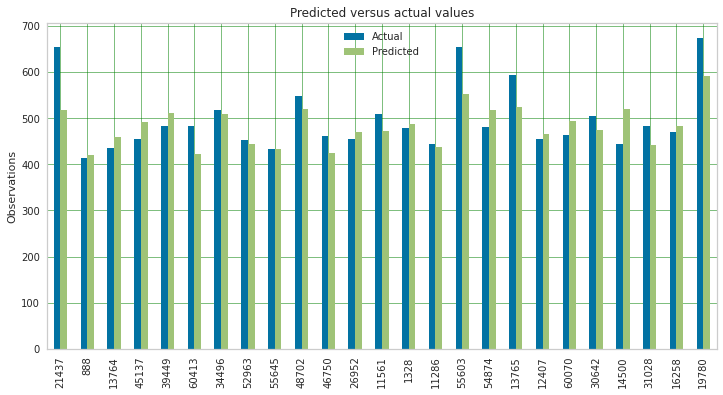

In [ ]:
build_mlr_model(pd_all_stations_clean, 'CO2')

## Build a model without categorical variables

In [ ]:
pd_all_stations_clean.columns

Index(['NO_x', 'NO2_x', 'PM10_x', 'CO2_x', 'TEMP_x', 'HUMI_x', 'NO_y', 'NO2_y',
       'PM10_y', 'PM2.5', 'CO2_y', 'TEMP_y', 'HUMI_y', 'hour', 'weekday',
       'weekend', 'month', 'summer', 'CO2'],
      dtype='object')

In [ ]:
y = pd_all_stations_clean.CO2.copy()
X = pd_all_stations_clean.drop(cols_dummify, axis=1).copy()
X.drop('CO2', axis=1, inplace=True)

scaler = StandardScaler()
scaler.fit(X)

X_scld = pd.DataFrame(data=scaler.transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scld, y, test_size=0.3, random_state=101)

lr_all_stations_cont = LinearRegression()  
lr_all_stations_cont.fit(X_train, y_train)

y_pred = lr_all_stations_cont.predict(X_test)

colors = ['Positive' if c > 0 else 'Negative' for c in lr_all_stations_cont.coef_]

fig = px.bar(
    x=X_scld.columns, y=lr_all_stations_cont.coef_, color=colors,
    #color_discrete_sequence=['red', 'blue'],
    labels=dict(x='Feature', y='Linear coefficient'),
    title='Weight of each feature for predicting CO2 in F.R. station'
)
fig.show()

Visualize a few of our predicted values versus actual values

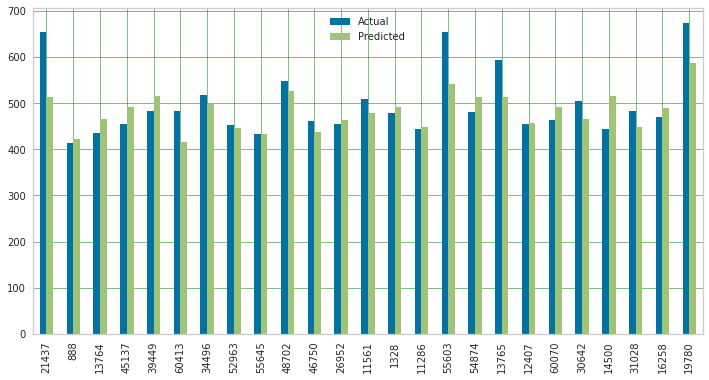

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

df1 = df.head(25)
df1.plot(kind='bar',figsize=(12,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

The above only gives us some qulitative appreciation for our predictions, so let's proceed with a more serios analysis of the quality of our model.

In [ ]:
X.head(3)

NO_x     NO2_x    PM10_x     CO2_x    TEMP_x    HUMI_x      NO_y  \
0  0.477646  2.486682 -0.230864  1.748174 -1.115377  0.160637  2.016104   
1  0.630552  2.150620 -0.089069  0.112599 -0.744078 -0.573117  0.033164   
2  3.535766  3.763719 -0.078162  1.424074 -0.915447 -0.515792  1.954618   

      NO2_y    PM10_y     PM2.5  ...  month_4   month_5   month_6   month_7  \
0  1.739118  2.171510  1.588638  ... -0.34098 -0.262828 -0.289643 -0.283569   
1  0.125292  2.039461  1.395083  ... -0.34098 -0.262828 -0.289643 -0.283569   
2  0.377452  3.791312  3.201595  ... -0.34098 -0.262828 -0.289643 -0.283569   

    month_8   month_9  month_10  month_11  month_12  summer_1  
0 -0.176397 -0.333966 -0.356091 -0.347284 -0.232149 -0.471697  
1 -0.176397 -0.333966 -0.356091 -0.347284 -0.232149 -0.471697  
2 -0.176397 -0.333966 -0.356091 -0.347284 -0.232149 -0.471697  

[3 rows x 55 columns]

In [ ]:
def cross_validation(X, Y, cv=5):
    r2_score_lr = cross_val_score(LinearRegression(), X, Y,cv=cv, scoring="r2")
    r2_score_ridge = cross_val_score(linear_model.Ridge(alpha=.5), X, Y,cv=cv, scoring="r2")
    r2_score_lasso = cross_val_score(linear_model.Lasso(alpha=0.8), X, Y,cv=cv, scoring="r2")
    print(f'R2 mean score simple lr: {r2_score_lr.mean():.3f}')
    print(f'R2 mean score ridge: {r2_score_ridge.mean():.3f}')
    print(f'R2 mean score lasso: {r2_score_lasso.mean():.3f}')

In [ ]:
cross_validation(X, y)

R2 mean score simple lr: 0.580
R2 mean score ridge: 0.580
R2 mean score lasso: 0.565


![Picture title](image-20201112-152655.png)

![Picture title](image-20201112-152656.png)